# Plot resobs based on observed inflow  taken from Steyaert et al., 2022 dataset

Based on: 
Hanasaki, N., Kanae, S., & Oki, T. (2006). A reservoir operation scheme for global river routing models. Journal of Hydrology, 327(1–2), 22–41. https://doi.org/10.1016/j.jhydrol.2005.11.011

Inne Vanderkelen -  May 2021



In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import xarray as xr
import os
import hydroeval as he
from datetime import datetime
import utils
import warnings
import seaborn as sns
import geopandas as gpd
# settings
warnings.filterwarnings('ignore')
utils.set_plot_param()

# constants
secperday   = 86400
secperhour  = 3600
dt          = 86400 # time of the modeling can be also hourly for mizuRout

daypermonth = 30 # average day in a month

# colorblind friendly colors 
colors_cbfriendly = {
    'blue':   '#377eb8',  
    'orange': '#ff7f00', 
    'green':  '#4daf4a', 
    'pink':   '#f781bf', 
    'brown':  '#a65628', 
    'purple': '#984ea3', 
    'gray':   '#999999', 
    'red':    '#e41a1c', 
    'yellow': '#dede00'
} 

### Settings

In [11]:
# define directories

# model directory
outdir = '/glade/work/ivanderk/mizuRoute_global/route/'

# current working directory
scriptsdir = os.getcwd() + '/'

# observations dir
obsdir = '/glade/work/ivanderk/data/ResOpsUS/'

sensitivity="_obsscaled"

# calculate outflow based on monthly timescale instead of daily
do_monthly = False
if do_monthly: 
    dt = 86400*daypermonth

# give simulation name
cases = ['nolake', 'natlake',  'H06_noirrig']#, 'H06_noirrig'] #'H06_noirrig'
cases_simple = ['nolake', 'natlake', 'H06']
cases_longname = ['NOLAKES', 'NAT', 'DAM_NOIRR' ]#, 'H06_noirrig']
colors = [ 'skyblue','yellowgreen', 'coral','gold' ]
colors = [ colors_cbfriendly['blue'], colors_cbfriendly['green'], colors_cbfriendly['orange'], colors_cbfriendly['yellow']]#'gold' ]

# open topology 
ntopo = xr.open_dataset(outdir+'ancillary_data/ntopo_hdma_mod.reorder_lake_H06'+sensitivity+'.nc')
ntopo_orig = xr.open_dataset(outdir+'ancillary_data/ntopo_hdma_mod.reorder_lake_H06.nc')

months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

monthly_fn = ''

panel_labels = ['a.', 'b.', 'c.', 'd.', 'e.', 'f.', 'g.', 'h.', 'i.', 'j.', 'k.', 'l.', 'm.', 'n.', 'o.', 'p.', 'q.', 'r.', 's.', 't.', 'u.', 'v.', 'w.']


In [12]:
# get metadata (similar to GRanD)
# this is already filered to contain all reservoirs in the hdma river network, manually using QGIS
df_attributes = gpd.read_file(obsdir+'ResOpsUS_attributes.shp') 

df_timeseries_inventory = pd.read_csv(obsdir+'attributes/time_series_inventory.csv')

# load lookup to link Grand IDs and hydrolake ids 
grand_id_lakeId_lookup = pd.read_csv('/glade/work/ivanderk/data/data_for_networktopology/grand_id_lakeId_lookup.csv')

gdf_grand = gpd.read_file('/glade/work/ivanderk/data/data_for_networktopology/GRanD_Version_1_3/GRanD_reservoirs_v1_3.shp')


# only keep reservoirs which are on HDMA river network

# make a selection of all dam ids with reservoirs with available storage and outflow start
df_inventory = df_timeseries_inventory[df_timeseries_inventory['OUTFLOW']==1][df_timeseries_inventory['STORAGE']==1][df_timeseries_inventory['INFLOW']==1]
df_inventory = df_inventory[df_inventory['DAM_ID'].isin(df_attributes['DAM_ID'])]

ind1 = df_inventory.index[df_inventory['DAM_ID'] == 138]  # Lake Alamor
ind2 = df_inventory.index[df_inventory['DAM_ID'] == 1275] # Sam Rayburn Dam and Reservoir

df_inventory.drop(index=ind1,inplace=True)
df_inventory.drop(index=ind2,inplace=True)


lakeids = grand_id_lakeId_lookup.loc[grand_id_lakeId_lookup['GRAND_ID'].isin(df_inventory['DAM_ID']),'lakeId'].values

                                                        
# get their pfafs as list 
#res_pfafs


In [13]:
names = []
for i,dam_id in enumerate(df_inventory['DAM_ID']):
    # find reservoir index
        # get name for reservoir

    names.append(df_attributes.loc[df_attributes['DAM_ID'] == dam_id,'DAM_NAME'].values[0])


In [16]:
# Hanasaki function

def Hanasaki (# Hanasaki inputs
              S, #storage at the current time step
              I, # upstream inflow
              D, # demand provided by the from outside mizuRoute
              # Hanasaki paraemters
              Par_flag_purpose, # porpouse of the lake, True if irrigation
              Par_Smax, # maximume storage of the reservoir
              # inflow
              Par_I_month, # inflow 12 timesteps for each month starting from january
              Par_flag_I, # flag telling to move to simulated inflow by mizuRoute
              Par_Mem_I,
              # demand
              Par_D_month, # demand 12 timesteps for each month starting from january
              Par_flag_D, # flag telling to move to the provided demand from outside of mizuRoute
              Par_Mem_D,
              # paraemters/coefficient
              Par_alpha, # storage activity
              Par_envfact, # Environmetal flow requirement
              Par_release_ini, # inital value of release coefficient if simulation not starting at first operational month
              Par_C1, # Coefficient 1
              Par_C2,# coefficient 2
              Par_power, # power
              Par_dinominator, # dinominator
              Par_c_compare,  # for daily release - IV: not clear to me why you use this variable? it replace 0.5 in comparison with c
              Par_deadstor, # paraemter for comparison to dead storage (percentage of maximume storage)
              # state/memory array
              Mem_I, # legth of the memory for inflow in year
              Mem_D, # length of the memory for demand in year
              # simulation paraemters
              yyyy,    # current simulation year 
              mm,      # current simulation month
              dd,      # current simulation day
              hh,      # current simulation hour
              mi,      # current simulation minute
              ss,      # current simulation second
              i_local,dt):      # time steps of simulation; i = 1 the initial time step and dt of simulation
    
    # this is a global flag which will be called inside in readl mizuRoute code; here is hardcoded:
    #Water_management = True;
    # add inflow to storage
    S = S + I*dt

    # calculation of Hansaki dependent parameters
    # yearly average inflow to the reservoir
    if Par_flag_I: # starting from inflow paraemter and transition to the mizuRoute inflow to lakes 
        if Mem_I is None: # if memory is nan it should be allocated [equivalant of allcation in Fortran]
            # 12 month and the number of time steps to be saved from the past
            Mem_I = np.zeros ([12,np.floor(secperday/dt*daypermonth*Par_Mem_I).astype(int)])
            for i in np.arange(12):
                Mem_I[i,:] = Mem_I[i,:]+Par_I_month[i] # populate the 2D vector for the model
        else: # is allocated so shift the Mem_I and give the inflow, I, to the proper index
            # shift one time step and put the value in its right place
            Mem_I [mm-1,1:] = Mem_I [mm-1,:-1]
            Mem_I [mm-1,0] = I
        # calculate the yearly input
        I_yearly = Mem_I.mean()
        Par_I_month = Mem_I.mean(axis=1) # update the parameters field 
    else:
        I_yearly = Par_I_month.mean()


    # yearly average demand to the reservoir
    if Par_flag_D: # starting from demand parameter and transition to the mizuRoute demand to lakes
#         if not Water_management:
#             print('need demand values Water_management flag should be true')
#             sys.exit()
        if Mem_D is None: # if memory is nan it should be allocated [equivalant of allcation in Fortran]
            # 12 month and the number of time steps to be saved from the past
            Mem_D = np.zeros ([12,np.floor(secperday/dt*daypermonth*Par_Mem_D).astype(int)])
            for i in np.arange(12):
                Mem_D[i,:] = Mem_D[i,:]+Par_D_month[i] # populate the 2D vector for the model
        else: # is allocated so shift the Mem_I and give the inflow, I, to the proper index
            # shift one time step and put the value in its right place
            Mem_D [mm-1,1:] = Mem_D [mm-1,:-1]
            Mem_D [mm-1,0] = D
        # calculate the yearly input
        D_yearly = Mem_D.mean()
        Par_D_month = Mem_D.mean(axis=1) # update the parameters field 
    else:
        D_yearly = Par_D_month.mean()
        
    # calculate storage to yearly activity ratio
    c = Par_Smax / (I_yearly * 365 * 86400)
    
    # finding the start month of the operational year and release
    E_release = Par_release_ini 
    
    temp = np.arange(12) # index 0 to 11
    #temp = temp [::-1] # reverse
    for i in temp:
        if I_yearly <= Par_I_month[i-1]: # finding the first month
            start_month = i+1 # start of the month; this can be passed once in the mizuRoute real code.
        # IV: to have the first where I_yearly > Par_I_month, start_month should be +1? Replacing i with i-1 should do the job
    #print(start_month)

    if mm == start_month and dd ==1:
        E_release = S / (Par_Smax*Par_alpha); # replace release from inital value to actual value
        
    if Par_flag_purpose:
        if Par_envfact * I_yearly <= D_yearly:
            target = Par_I_month[mm-1] * Par_C1 + I_yearly * (Par_D_month[mm-1]/D_yearly) * Par_C2
        else:
            target = I_yearly + Par_D_month[mm-1] - D_yearly
    else:
        target = I_yearly
        
    # determine the actual reservoir release
    if c >= Par_c_compare: # "multi-year reservoir"
        release_daily = target * E_release
    elif 0 <= c and c < Par_c_compare: # "whitin-a-year reservoir"
        release_daily = (c/Par_dinominator)**Par_power * E_release * target + (1-(c/Par_dinominator)**Par_power)* I
        
    # scaling of the daily release based on the sotrage in comparison with the dead storage
    # 1. adjust release so that reservoir does not empty (S goes below dead storage, can be defined as 0.1 of maximum storage, e.g. Biemans 2011, or as 0)
    # this introduces yet another parameter though ... What do you think? 
    # I see you already accounted for this in the lake code
    if S < Par_Smax * Par_deadstor: # if reservoir storage falls below the dead storage, subtract the difference from the daily release value 
        
        release_daily = release_daily - (Par_Smax * Par_deadstor - S) / (dt)
        
         # make negative release not possible
        if release_daily < 0: 
            release_daily = 0
        
    # 2. Adjust release to account for spilling releases (storage exceeds max storage, all abundant water is released)    
    elif S > Par_Smax: 
        release_daily = release_daily + (S - Par_Smax)  / (dt)

    S = S - (release_daily)*dt

    return S, Mem_I, Mem_D, i_local , release_daily, Par_I_month, Par_D_month, E_release
        
    
    

## Do Hanasaki

In [ ]:
# load capacity ratio dataframe
df_c = pd.read_csv(scriptsdir+'results_resobs_pythoncode/capacity_ratio.csv')

In [25]:
case = 'H06'
print(case)


for i,dam_id in enumerate(df_inventory['DAM_ID']):

    # find reservoir index
        # get name for reservoir
    reservoir_name = df_attributes.loc[df_attributes['DAM_ID'] == dam_id,'DAM_NAME'].values[0]

    # get pfaf for reservoir
    lakeid = grand_id_lakeId_lookup.loc[grand_id_lakeId_lookup['GRAND_ID']==dam_id,'lakeId'].values[0]
    res_pfaf =  ntopo['PFAF'].where(ntopo['lakeId']==lakeid, drop=True).values

    
    print('calculating '+reservoir_name)

    ## 1. Load the data and parameters per reservoir

    # get parameter from reservoir from ntopo
    Par_Smax = gdf_grand.loc[gdf_grand['GRAND_ID']==dam_id, 'CAP_MCM'].values[0]*10e6 
    

    # initial parameters:
    if gdf_grand.loc[gdf_grand['GRAND_ID']==dam_id, 'MAIN_USE'].values[0] =='Irrigation': 
        Par_flag_purpose = True # porpouse of the lake, True if irrigation
    else: 
        Par_flag_purpose = False # porpouse of the lake, True if irrigation

    # load observations
    df_obs = pd.read_csv(obsdir+'time_series_all/ResOpsUS_'+str(int(dam_id))+'.csv').rename(columns={'date':'time'})
    df_obs['storage'] = df_obs['storage']*10e6 # from mcm³ to m³

    df_obs.index = pd.to_datetime(df_obs.time)
    df_obs.index = df_obs.index.normalize() # turn observations of 12h to 00h 
    
    timestep = 'daily' if (df_obs.index[1]).day - (df_obs.index[0]).day == 1 else 'monthly'
    monthly_fn = ''
    if timestep=='monthly': 
        
        # problem with februari: this value is assigned to january 30. Replace manually to february
        timestamp_old = pd.to_datetime(df_obs.loc[str(pd.to_datetime(df_obs.time).iloc[1].year)+'-01-31']['time']).normalize()
        timestamp_new = timestamp_old.replace(month=2,day=1).normalize()
        df_obs.rename(index={df_obs.index[1]:timestamp_new},inplace=True)
        df_obs = df_obs.resample('M').mean()
        
        
        # give all days value 1
        ds = df_obs.index.to_series()
        df_obs = df_obs.set_index(pd.Index(ds.apply(lambda dt: dt.replace(day=1))))
        
            #monthly_fn = '_mon'
        dt = secperday * daypermonth
    else: 
        dt = secperday
    
    outflow_obs = df_obs['outflow']
    storage_obs = df_obs['storage']
    inflow = df_obs['inflow']


    # get purpose string from metadata 
    purpose = gdf_grand.loc[gdf_grand['GRAND_ID']==dam_id, 'MAIN_USE'].values[0]


    ## 2. Set Hanasaki parameters from network topology

    # inflow
    Par_I_month = df_obs.groupby([df_obs.index.month]).mean()['inflow'].to_numpy() # calculate for specific reservoir. *2


    Par_flag_I = False
    Par_Mem_I = 5


    # demand
    Par_D_month = []
    for month in months: Par_D_month.append(ntopo_res['H06_D_'+month].values[0])
    Par_D_month = np.array(Par_D_month)
    
    Par_flag_D = ntopo_res['H06_D_mem_F'].values[0] # flag telling to move to the provided demand from outside of mizuRoute
    Par_Mem_D = ntopo_res['H06_D_mem_L'].values[0] # years

    # parameters/coefficient
    Par_alpha = ntopo_res['H06_alpha'].values[0] # storage activity
    Par_envfact = ntopo_res['H06_envfact'].values[0] # Environmetal flow requirement 
    Par_release_ini = ntopo_res['H06_E_rel_ini'].values[0] # inital value assuming the storage of the first time step
    Par_C1 = ntopo_res['H06_c1'].values[0] # Coefficient 1
    Par_C2 = ntopo_res['H06_c2'].values[0] # coefficient 2
    Par_power = ntopo_res['H06_exponent'].values[0] # power
    Par_dinominator = ntopo_res['H06_denominator'].values[0] 
    Par_c_compare = ntopo_res['H06_c_compare'].values[0]   
    Par_deadstor = ntopo_res['H06_frac_Sdead'].values[0] 
    Mem_D =[] # nothing to start with
    Mem_I = []# nothing to start with
    counter = 1 # model counter
    
    ## 3. Do Hanasaki simulation

    S_time_series = np.zeros(len(df_obs))
    O_time_series = np.zeros(len(df_obs))

    # initialise first timestep
    
    S_time_series [0] = df_obs['storage'][0].item()
    O_time_series [0] = df_obs['outflow'][0].item()
    
    for date in df_obs.index[1:]: # loop over the time period

        yyyy = date.year
        mm = date.month
        dd = date.day
        hh = date.hour
        mi = date.minute
        ss = date.second

        if counter == 1:
            S = df_obs.iloc[df_obs.index == date]['storage'].item()

        I = df_obs.iloc[df_obs.index == date]['inflow'].item()
        D = []

        S, Mem_I, Mem_D, i_local , release_daily, Par_I_month, Par_D_month, Par_release_ini = Hanasaki (S, #storage at the current time step
                  I, # upstream inflow
                  D, # demand provided by the from outside mizuRoute
                  # Hanasaki parameters
                  Par_flag_purpose, # porpouse of the lake, True if irrigation
                  Par_Smax, # maximume storage of the reservoir
                  # inflow
                  Par_I_month, # inflow 12 timesteps for each month starting from january
                  Par_flag_I, # flag telling to move to simulated inflow by mizuRoute
                  Par_Mem_I,
                  # demand
                  Par_D_month, # demand 12 timesteps for each month starting from january
                  Par_flag_D, # flag telling to move to the provided demand from outside of mizuRoute
                  Par_Mem_D,
                  # paraemters/coefficient
                  Par_alpha, # storage activity
                  Par_envfact, # Environmetal flow requirement
                  Par_release_ini, # inital value of release coefficient if simulation not starting at first operational month
                  Par_C1, # Coefficient 1
                  Par_C2,# coefficient 2
                  Par_power, # power
                  Par_dinominator, # dinominator
                  Par_c_compare,  # for daily release - IV: not clear to me why you use this variable? it replace 0.5 in comparison with c
                  Par_deadstor,
                  # state/memory array
                  Mem_I, # legth of the memory for inflow in year
                  Mem_D, # length of the memory for demand in year
                  # simulation paraemters
                  yyyy,    # current simulation year 
                  mm,      # current simulation month
                  dd,      # current simulation day
                  hh,      # current simulation hour
                  mi,      # current simulation minute
                  ss,      # current simulation second
                  counter,
                  dt)     # time steps of simulation; i = 1 the initial time step of the model

        S_time_series [counter] = S
        O_time_series [counter] = release_daily

        counter = counter + 1

    ## 4. Save results in csvfile
    result = pd.DataFrame()
    result ['storage'] =  S_time_series
    result ['outflow'] =  O_time_series
    result ['storage_observed'] =  np.array(storage_obs)
    result ['outflow_observed'] =  np.array(outflow_obs)
    result ['inflow']  =  np.array(inflow)
    result.index = df_obs.index

    result.to_csv(scriptsdir+'results_resobs_pythoncode/'+reservoir_name+'_'+case+monthly_fn+'_resopsus.csv')
    
    ## 5. Save capacity ratio in seperate dict
    c = Par_Smax / (Par_I_month.mean() * 365 * 86400)

df_c.to_csv(scriptsdir+'results_resobs_pythoncode/capacity_ratio.csv')


H06
calculating Shasta


NameError: name 'ntopo_res' is not defined

In [23]:
df_obs

,time,storage,inflow,outflow,elevation,evaporation
0,1945-01-01,NaN,214.354,NaN,NaN,NaN
1,1945-01-02,NaN,203.269,NaN,NaN,NaN
2,1945-01-03,NaN,190.243,NaN,NaN,NaN
3,1945-01-04,NaN,186.101,NaN,NaN,NaN
4,1945-01-05,NaN,184.296,NaN,NaN,NaN
...,...,...,...,...,...,...
27754,2020-12-27,2.500419e+10,NaN,83.138,NaN,NaN
27755,2020-12-28,2.502131e+10,NaN,76.682,NaN,NaN
27756,2020-12-29,2.504276e+10,NaN,77.588,NaN,NaN
27757,2020-12-30,2.505998e+10,NaN,88.660,NaN,NaN


## Do Hanasaki for all reservoirs, assuming they are all no irrig reservoirs. 

In [31]:
case = 'H06_noirrig'
print(case)

for i,dam_id in enumerate(df_inventory['DAM_ID']):

    # find reservoir index
        # get name for reservoir
    reservoir_name = df_attributes.loc[df_attributes['DAM_ID'] == dam_id,'DAM_NAME'].values[0]

    # get pfaf for reservoir
    lakeid = grand_id_lakeId_lookup.loc[grand_id_lakeId_lookup['GRAND_ID']==dam_id,'lakeId'].values[0]
    res_pfaf =  ntopo['PFAF'].where(ntopo['lakeId']==lakeid, drop=True).values

    
    print('calculating '+reservoir_name)

    ## 1. Load the data and parameters per reservoir

    # get parameter from reservoir from ntopo
    Par_Smax = gdf_grand.loc[gdf_grand['GRAND_ID']==dam_id, 'CAP_MCM'].values[0]*10e6 
   
    # initial parameters:
    # always false - no irrig. 
    Par_flag_purpose = False # porpouse of the lake, True if irrigation

    # load observations
    df_obs = pd.read_csv(obsdir+'time_series_all/ResOpsUS_'+str(int(dam_id))+'.csv').rename(columns={'date':'time'})
    df_obs['storage'] = df_obs['storage']*10e6 # from mcm³ to m³
    df_obs.index = pd.to_datetime(df_obs.time)
    df_obs.index = df_obs.index.normalize() # turn observations of 12h to 00h 
    monthly_fn = ''
    timestep = 'daily' if (df_obs.index[1]).day - (df_obs.index[0]).day == 1 else 'monthly'

    if timestep=='monthly': 
        
        # problem with februari: this value is assigned to january 30. Replace manually to february
        timestamp_old = pd.to_datetime(df_obs.loc[str(pd.to_datetime(df_obs.time).iloc[1].year)+'-01-31']['time']).normalize()
        timestamp_new = timestamp_old.replace(month=2,day=1).normalize()
        df_obs.rename(index={df_obs.index[1]:timestamp_new},inplace=True)
        df_obs = df_obs.resample('M').mean()
        
        
        # give all days value 1
        ds = df_obs.index.to_series()
        df_obs = df_obs.set_index(pd.Index(ds.apply(lambda dt: dt.replace(day=1))))
        
            #monthly_fn = '_mon'
        dt = secperday * daypermonth
    else: 
        dt = secperday
    
    outflow_obs = df_obs['outflow']
    storage_obs = df_obs['storage']
    inflow = df_obs['inflow']

    # get purpose string from metadata 
    purpose = gdf_grand.loc[gdf_grand['GRAND_ID']==dam_id, 'MAIN_USE'].values[0] 

    ## 2. Set Hanasaki parameters from network topology

    # inflow
    #Par_I_month = np.array([9, 9,10,18.64,58,132,59,41,42,27,12,10]) # inflow 12 timesteps for each month starting from january
    Par_I_month = df_obs.groupby([df_obs.index.month]).mean()['inflow'].to_numpy() # calculate for specific reservoir. 


    Par_flag_I = False
    Par_Mem_I = 5

    # demand
    Par_D_month = []
    Par_D_month = np.zeros_like(Par_I_month)

    Par_flag_D = False #flag telling to move to the provided demand from outside of mizuRoute
    Par_Mem_D = 5

    # parameters/coefficient
    Par_alpha = 0.85 # storage activity
    Par_envfact = 0.9 # Environmetal flow requirement 
    Par_release_ini = 0.8# inital value assuming the storage of the first time step
    Par_C1 = 0.1
    Par_C2 = 0.9
    Par_power = 2
    Par_dinominator = 0.5
    Par_c_compare = 0.5
    Par_deadstor = 0.1
    Mem_D =[] # nothing to start with
    Mem_I = []# nothing to start with
    counter = 0 # model counter


    ## 3. Do Hanasaki simulation

    S_time_series = np.zeros(len(df_obs))
    O_time_series = np.zeros(len(df_obs))

    for date in df_obs.index: # loop over the time period

        yyyy = date.year
        mm = date.month
        dd = date.day
        hh = date.hour
        mi = date.minute
        ss = date.second

        if counter == 0:
            S = df_obs.iloc[df_obs.index == date]['storage'].item()
        I = df_obs.iloc[df_obs.index == date]['inflow'].item()
        D = []

        S, Mem_I, Mem_D, i_local , release_daily, Par_I_month, Par_D_month, Par_release_ini = Hanasaki (S, #storage at the current time step
                  I, # upstream inflow
                  D, # demand provided by the from outside mizuRoute
                  # Hanasaki parameters
                  Par_flag_purpose, # porpouse of the lake, True if irrigation
                  Par_Smax, # maximume storage of the reservoir
                  # inflow
                  Par_I_month, # inflow 12 timesteps for each month starting from january
                  Par_flag_I, # flag telling to move to simulated inflow by mizuRoute
                  Par_Mem_I,
                  # demand
                  Par_D_month, # demand 12 timesteps for each month starting from january
                  Par_flag_D, # flag telling to move to the provided demand from outside of mizuRoute
                  Par_Mem_D,
                  # paraemters/coefficient
                  Par_alpha, # storage activity
                  Par_envfact, # Environmetal flow requirement
                  Par_release_ini, # inital value of release coefficient if simulation not starting at first operational month
                  Par_C1, # Coefficient 1
                  Par_C2,# coefficient 2
                  Par_power, # power
                  Par_dinominator, # dinominator
                  Par_c_compare,  # for daily release - IV: not clear to me why you use this variable? it replace 0.5 in comparison with c
                  Par_deadstor,
                  # state/memory array
                  Mem_I, # legth of the memory for inflow in year
                  Mem_D, # length of the memory for demand in year
                  # simulation paraemters
                  yyyy,    # current simulation year 
                  mm,      # current simulation month
                  dd,      # current simulation day
                  hh,      # current simulation hour
                  mi,      # current simulation minute
                  ss,      # current simulation second
                  counter,
                  dt)     # time steps of simulation; i = 1 the initial time step of the model

        S_time_series [counter] = S
        O_time_series [counter] = release_daily

        counter = counter + 1

    ## 4. Save results in csvfile
    result = pd.DataFrame()
    result ['storage'] =  S_time_series
    result ['outflow'] =  O_time_series
    result ['storage_observed'] =  np.array(storage_obs)
    result ['outflow_observed'] =  np.array(outflow_obs)
    result ['inflow']  =  np.array(inflow)
    result.index = df_obs.index

    result.to_csv(scriptsdir+'results_resobs_pythoncode/'+reservoir_name+'_'+case+monthly_fn+'_resopsus.csv')


H06_noirrig
calculating Shasta
calculating Libby
calculating Fort Peck Dam
calculating Grand Coulee
calculating Kerr
calculating Jackson Lake
calculating Flaming Gorge
calculating Glen Canyon
calculating Elephant Butte Dike
calculating Garrison Dam
calculating Winnibigoshish Dam
calculating Oahe Dam
calculating Big Bend Dam
calculating Kingsley
calculating Harry S. Truman Dam
calculating Bagnell Dam
calculating Table Rock Dam
calculating Oologah Lake
calculating Bull Shoals
calculating Greers Ferry
calculating Robert S. Kerr Lock and Dam
calculating Blakely Mountain Dam
calculating Barkley Dam
calculating Kentucky
calculating Wolf Creek
calculating John H. Kerr Dam
calculating Sardis Dam
calculating Hartwell Dam
calculating Grenada Dam
calculating J. Strom Thurmond Dam
calculating Walter F. George Lock and Dam
calculating North Santee Dam


## Do Döll

In [32]:
case = 'natlake'
print(case)

for i,dam_id in enumerate(df_inventory['DAM_ID']):

    # find reservoir index
        # get name for reservoir
    reservoir_name = df_attributes.loc[df_attributes['DAM_ID'] == dam_id,'DAM_NAME'].values[0]

    # get pfaf for reservoir
    lakeid = grand_id_lakeId_lookup.loc[grand_id_lakeId_lookup['GRAND_ID']==dam_id,'lakeId'].values[0]
    res_pfaf =  ntopo['PFAF'].where(ntopo['lakeId']==lakeid, drop=True).values

    
    print('calculating '+reservoir_name)

    ## 1. Load the data and parameters per reservoir

    # get parameter from reservoir from ntopo
    max_storage = gdf_grand.loc[gdf_grand['GRAND_ID']==dam_id, 'CAP_MCM'].values[0]*10e6 
   
    # get parameter from reservoir from ntopo
    release_coef = 0.01
    exponent = 1.5


    # load observations
    df_obs = pd.read_csv(obsdir+'time_series_all/ResOpsUS_'+str(int(dam_id))+'.csv').rename(columns={'date':'time'})
    df_obs['storage'] = df_obs['storage']*10e6 # from mcm³ to m³
    df_obs.index = pd.to_datetime(df_obs.time)
    df_obs.index = df_obs.index.normalize() # turn observations of 12h to 00h 
    monthly_fn = ''
    timestep = 'daily' if (df_obs.index[1]).day - (df_obs.index[0]).day == 1 else 'monthly'

    if timestep=='monthly': 
        
        # problem with februari: this value is assigned to january 30. Replace manually to february
        timestamp_old = pd.to_datetime(df_obs.loc[str(pd.to_datetime(df_obs.time).iloc[1].year)+'-01-31']['time']).normalize()
        timestamp_new = timestamp_old.replace(month=2,day=1).normalize()
        df_obs.rename(index={df_obs.index[1]:timestamp_new},inplace=True)
        df_obs = df_obs.resample('M').mean()
        
        
        # give all days value 1
        ds = df_obs.index.to_series()
        df_obs.set_index(pd.Index(ds.apply(lambda dt: dt.replace(day=1))))
        
            #monthly_fn = '_mon'
        dt = secperday * daypermonth
    else: 
        dt = secperday
        
    outflow_obs = df_obs['outflow']
    storage_obs = df_obs['storage']
    inflow = df_obs['inflow']


    # initialise empty data series
    outflow = pd.Series(index=inflow.index, dtype='float64')
    storage = pd.Series(index=inflow.index, dtype='float64')

    # assign first storage (possible for spin up: use maximum capacity and let reservoir empty during spin up)
    storage[0] = storage_obs[0]

    outflow[0] = inflow[0]

    # loop over timesteps (days)
    for t, inflow_day in enumerate(inflow): 

        # adjust storage based on inflow and outflow of day
        if t > 0:
            storage[t] = storage[t-1] + (inflow_day-outflow[t-1])*dt
        
        outflow[t] = release_coef  * storage[t] * (storage[t]/max_storage)**exponent
    

    ## 4. Save results in csvfile
    result = pd.DataFrame()
    
    result ['storage'] =  storage
    result ['outflow'] =  outflow
    result ['storage_observed'] =  np.array(storage_obs)
    result ['outflow_observed'] =  np.array(outflow_obs)
    result ['inflow']  =  np.array(inflow)
    result.index = df_obs.index

    result.to_csv(scriptsdir+'results_resobs_pythoncode/'+reservoir_name+'_'+case+monthly_fn+'_resopsus.csv')


natlake
calculating Shasta
calculating Libby
calculating Fort Peck Dam
calculating Grand Coulee
calculating Kerr
calculating Jackson Lake
calculating Flaming Gorge
calculating Glen Canyon
calculating Elephant Butte Dike
calculating Garrison Dam
calculating Winnibigoshish Dam
calculating Oahe Dam
calculating Big Bend Dam
calculating Kingsley
calculating Harry S. Truman Dam
calculating Bagnell Dam
calculating Table Rock Dam
calculating Oologah Lake
calculating Bull Shoals
calculating Greers Ferry
calculating Robert S. Kerr Lock and Dam
calculating Blakely Mountain Dam
calculating Barkley Dam
calculating Kentucky
calculating Wolf Creek
calculating John H. Kerr Dam
calculating Sardis Dam
calculating Hartwell Dam
calculating Grenada Dam
calculating J. Strom Thurmond Dam
calculating Walter F. George Lock and Dam
calculating North Santee Dam


In [33]:
"""
#for reservoir_name in names:
df = pd.DataFrame()
df['reservoir_name'] =  names

for reservoir_name in names:

    ## 1. Load the data and parameters per reservoir
    # load observations
    fn = obsdir+'res_info_out_'+reservoir_name+'.csv'
    df_obs = pd.read_csv(fn)
    df_obs.index = pd.to_datetime(df_obs.timed)
    df_obs.index = df_obs.index.normalize() # turn observations of 12h to 00h 

    df.loc[df['reservoir_name']==reservoir_name,'period'] = str(df_obs.index[0].year) + '-'+str(df_obs.index[-1].year)    
    df.loc[df['reservoir_name']==reservoir_name,'years'] = np.round(df_obs.index[-1].year - df_obs.index[0].year)


df.to_csv(scriptsdir+'results_resobs_pythoncode/reservoirs_simulationperiod.csv')

"""

"\n#for reservoir_name in names:\ndf = pd.DataFrame()\ndf['reservoir_name'] =  names\n\nfor reservoir_name in names:\n\n    ## 1. Load the data and parameters per reservoir\n    # load observations\n    fn = obsdir+'res_info_out_'+reservoir_name+'.csv'\n    df_obs = pd.read_csv(fn)\n    df_obs.index = pd.to_datetime(df_obs.timed)\n    df_obs.index = df_obs.index.normalize() # turn observations of 12h to 00h \n\n    df.loc[df['reservoir_name']==reservoir_name,'period'] = str(df_obs.index[0].year) + '-'+str(df_obs.index[-1].year)    \n    df.loc[df['reservoir_name']==reservoir_name,'years'] = np.round(df_obs.index[-1].year - df_obs.index[0].year)\n\n\ndf.to_csv(scriptsdir+'results_resobs_pythoncode/reservoirs_simulationperiod.csv')\n\n"

## Do nolakes (outflow=inflow)

In [36]:
case = 'nolake'
print(case)
for i,dam_id in enumerate(df_inventory['DAM_ID']):

    # find reservoir index
        # get name for reservoir
    reservoir_name = df_attributes.loc[df_attributes['DAM_ID'] == dam_id,'DAM_NAME'].values[0]

    print('calculating '+reservoir_name)

    ## 1. Load the data and parameters per reservoir

    # load observations
    df_obs = pd.read_csv(obsdir+'time_series_all/ResOpsUS_'+str(int(dam_id))+'.csv').rename(columns={'date':'time'})
    df_obs['storage'] = df_obs['storage']*10e6 # from mcm³ to m³
    
    
    df_obs.index = pd.to_datetime(df_obs.time)
    df_obs.index = df_obs.index.normalize() # turn observations of 12h to 00h 
    if do_monthly: 
            df_obs = df_obs.resample('M').mean()
            monthly_fn = '_mon'    
    outflow_obs = df_obs['outflow']
    storage_obs = df_obs['storage']
    inflow = df_obs['inflow']


    # initialise empty data series
    outflow = inflow
    storage = pd.Series(np.zeros_like(inflow.values),index=inflow.index, dtype='float64')

    ## 4. Save results in csvfile
    result = pd.DataFrame()
    result ['storage'] =  storage
    result ['outflow'] =  outflow
    result ['storage_observed'] =  np.array(storage_obs)
    result ['outflow_observed'] =  np.array(outflow_obs)
    result ['inflow']  =  np.array(inflow)
    result.index = df_obs.index

    result.to_csv(scriptsdir+'results_resobs_pythoncode/'+reservoir_name+'_'+case+monthly_fn+'_resopsus.csv')


nolake
calculating Shasta
calculating Libby
calculating Fort Peck Dam
calculating Grand Coulee
calculating Kerr
calculating Jackson Lake
calculating Flaming Gorge
calculating Glen Canyon
calculating Elephant Butte Dike
calculating Garrison Dam
calculating Winnibigoshish Dam
calculating Oahe Dam
calculating Big Bend Dam
calculating Kingsley
calculating Harry S. Truman Dam
calculating Bagnell Dam
calculating Table Rock Dam
calculating Oologah Lake
calculating Bull Shoals
calculating Greers Ferry
calculating Robert S. Kerr Lock and Dam
calculating Blakely Mountain Dam
calculating Barkley Dam
calculating Kentucky
calculating Wolf Creek
calculating John H. Kerr Dam
calculating Sardis Dam
calculating Hartwell Dam
calculating Grenada Dam
calculating J. Strom Thurmond Dam
calculating Walter F. George Lock and Dam
calculating North Santee Dam


## Load simulations, calculate scores and do plotting

In [15]:
# load simulations into dict per case - same as is done with mizuRoute simulations
spinup = 0 # year

df_mod_dict = {}
res_info = {}
kge_dict = {}
r_dict = {}
alpha_dict = {}
beta_dict = {}
nse_dict = {}
rmse_dict = {}
mare_dict = {}
pbias_dict = {}

names_daily = [] # array to save reservoirs with daily observations


for i,dam_id in enumerate(df_inventory['DAM_ID']):

    # find reservoir index
        # get name for reservoir
    reservoir_name = df_attributes.loc[df_attributes['DAM_ID'] == dam_id,'DAM_NAME'].values[0]

    res_dict = {}
    
    ### calculate scores for outflow 
    variable = 'storage'
    kge_res_dict = {}
    r_res_dict = {}
    alpha_res_dict = {}
    beta_res_dict = {}
    nse_res_dict = {}
    rmse_res_dict = {}
    mare_res_dict = {}
    pbias_res_dict = {}
    

    lakeid = grand_id_lakeId_lookup.loc[grand_id_lakeId_lookup['GRAND_ID']==dam_id,'lakeId'].values[0]

    res_pfaf =  ntopo['PFAF'].where(ntopo['lakeId']==lakeid, drop=True).values

    for case in cases: 
        df = pd.read_csv(scriptsdir+'results_resobs_pythoncode/'+reservoir_name+'_'+case+'_resopsus.csv')
        if do_monthly: 
            df = pd.read_csv(scriptsdir+'results_resobs_pythoncode/'+reservoir_name+'_'+case+'_mon.csv') 
            
        df.index = df['time']
        df.index = pd.to_datetime(df.index)

        # only continue if daily obs are available (for now)
        # determine timestep of observations (to account for monthly)
        
        if not ((df.index[1]).day - (df.index[0]).day == 1) or do_monthly: # monthly observations
            df_timestep = df.resample('M').mean()
        else: 
            df_timestep = df
            
        if case==cases[0]:
            names_daily.append(reservoir_name)

        start_year = df.index.year[1]+spinup
        df_timestep = df_timestep[df_timestep.index.year >=start_year] 
        res_dict[case]  = df_timestep

        # get reservoir info and save
        inflow_mean = df['inflow'].mean() * 86400 * 365 # m³/year

        res_pfaf =  ntopo['PFAF'].where(ntopo['lakeId']==lakeid, drop=True)

        # get parameter from reservoir from ntopo
        max_storage = gdf_grand.loc[gdf_grand['GRAND_ID']==dam_id, 'CAP_MCM'].values[0]*10e6 

        c = max_storage/inflow_mean
        if c>0.5: res_size='multi-year'
        else: res_size='within-a-year'

        if  gdf_grand.loc[gdf_grand['GRAND_ID']==dam_id, 'MAIN_USE'].values[0] =='Irrigation': res_type='irrigation'
        else: res_type='non-irrigation'

        # save information on reservoir
        res_info[reservoir_name] = {'purpose': res_type, 'size': res_size, 'Smax' : max_storage}

        kge_res_dict_var = {}
        r_res_dict_var = {}
        alpha_res_dict_var = {}
        beta_res_dict_var = {}
        nse_res_dict_var = {}
        rmse_res_dict_var = {}
        mare_res_dict_var = {}
        pbias_res_dict_var = {}

        for variable in ['outflow','storage']: 

            kge_res_dict_var[variable], r_res_dict_var[variable], alpha_res_dict_var[variable], beta_res_dict_var[variable]    = he.evaluator(he.kge,df_timestep[variable+'_observed'].values,res_dict[case][variable].values)
            nse_res_dict_var[variable]   = he.evaluator(he.nse,df_timestep[variable+'_observed'].values,res_dict[case][variable].values)[0]
            rmse_res_dict_var[variable]  = he.evaluator(he.rmse,df_timestep[variable+'_observed'].values,res_dict[case][variable].values)[0]
            mare_res_dict_var[variable]  = he.evaluator(he.mare,df_timestep[variable+'_observed'].values,res_dict[case][variable].values)[0]
            pbias_res_dict_var[variable] = he.evaluator(he.pbias,df_timestep[variable+'_observed'].values,res_dict[case][variable].values)[0]

        kge_res_dict[case]   = kge_res_dict_var
        r_res_dict[case]     = r_res_dict_var       
        alpha_res_dict[case] = alpha_res_dict_var            
        beta_res_dict[case]  = beta_res_dict_var
        nse_res_dict[case]   = nse_res_dict_var
        rmse_res_dict[case]  = rmse_res_dict_var
        mare_res_dict[case]  = mare_res_dict_var
        pbias_res_dict[case] = pbias_res_dict_var

    #if ((df.index[1]).day - (df.index[0]).day == 1) or do_monthly: 

    res_dict[case]  = df_timestep

    df_mod_dict[reservoir_name] = res_dict

    kge_dict[reservoir_name] = kge_res_dict
    r_dict[reservoir_name] = r_res_dict
    alpha_dict[reservoir_name] = alpha_res_dict
    beta_dict[reservoir_name] = beta_res_dict
    nse_dict[reservoir_name] = nse_res_dict
    rmse_dict[reservoir_name] = rmse_res_dict
    mare_dict[reservoir_name] = mare_res_dict
    pbias_dict[reservoir_name] = pbias_res_dict

# replace names with daily names in continue
#names = names_daily
metrics_dict =  {'KGE': kge_dict, 'R': r_dict, 'alpha': alpha_dict, 'beta': beta_dict, 'NSE': nse_dict, 'RMSE': rmse_dict, 'MARE':mare_dict,'PBIAS':pbias_dict}       

# load capacity ratio per reservoir
df_c = pd.read_csv(scriptsdir+'results_resobs_pythoncode/capacity_ratio.csv')
names_sorted = df_c.sort_values(by='c').reset_index(drop=True).drop(columns='c')
names_sorted.columns =['name']
names_sorted['order'] = np.arange(0,len(names_sorted))


## Plots for paper

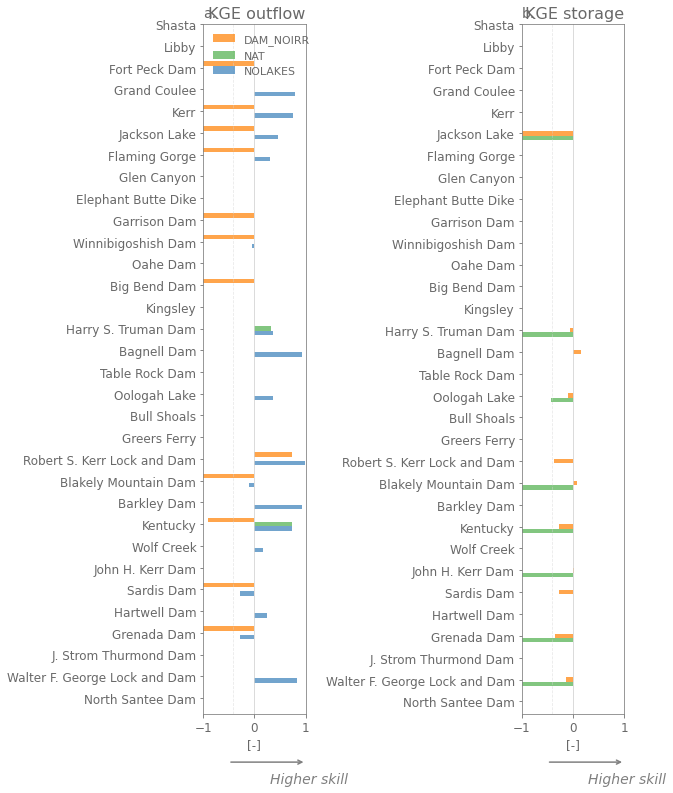

In [16]:
# plot metrics


# combine metrics in dict
#metrics_all_dict = {'KGE':kge_dict, 'R':r_dict,'alpha':alpha_dict, 'beta': beta_dict}
metrics_all_dict = {'KGE':kge_dict}

metric_names = {'KGE':'KGE', 'R':'correlation (r)','alpha':'variability bias ($\sigma_{mod}$/$\sigma_{obs})$', 'beta':' mean bias ($\mu_{mod}$/$\mu_{obs}$)'}
# initialise figure
fig, axes = plt.subplots(1,2, figsize=(9,11))

# sort data
metric = 'KGE'
metric_dict = metrics_all_dict[metric]

# irrigation reservoirs
reservoir_subset = list(names)

for n,variable in enumerate(['outflow','storage']):


    cases_toplot = cases

    if variable =='storage':
        cases_toplot = cases_toplot[1:]
        colors_toplot = colors[1:]
    else: 
        colors_toplot = colors

    scores = np.empty((len(cases_toplot),len(reservoir_subset)))
    reservoir_subset = list(names)
    reservoir_subset.reverse()

    for i,reservoir in enumerate(reservoir_subset):
        res_scores = []
        for case in cases_toplot: 
            res_scores.append(metric_dict[reservoir][case][variable].squeeze())
        scores[:,i] = np.array(res_scores)
  
    barWidth = 0.2  
    # Set position of bar on X axis
    barpositions = np.empty((len(cases_toplot),len(reservoir_subset)))
    barpositions[0,:] = np.arange(len(scores[0,:]))

    for i in range(1,barpositions.shape[0]):
        barpositions[i,:] =  [x + barWidth for x in barpositions[i-1,:] ]  
    ax = axes[n]

    for i,score in enumerate(scores):  
        ax.barh(barpositions[i,:], score,height = barWidth, label=cases_longname[i], color=colors_toplot[i], alpha=0.7)
    reservoir_subset_names = reservoir_subset
    ax.set_yticks([r + barWidth for r in range(len(barpositions[0,:]))])
    ax.set_yticklabels(reservoir_subset_names)
    ax.set_title(metric_names[metric]+' '+variable,loc='right', fontsize=16)
    ax.axvline(0, linewidth=0.8, color='lightgray')
    ax.axvline(-0.41, linewidth=0.8, color='lightgray', alpha=0.5, linestyle='--')

    ax.set_xlim([-1,1])
    ax.set_xlabel('[-]')
    ax.text(0, 1.01, panel_labels[n], color='dimgrey', fontsize=14, transform=ax.transAxes );
    
    ax.annotate('', xy=(0.25,-0.07), xycoords=("axes fraction"), xytext=(1,-0.07), arrowprops=dict(arrowstyle="<-", color="gray",linewidth=1.5));
    ax.annotate('Higher skill', xy=(0.65,-0.1), xycoords=("axes fraction"), xytext=(0.65,-0.1), fontsize=14, color="gray",style='italic'); 
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles[::-1], labels[::-1], fontsize=11, loc="upper left");



fig.tight_layout()
#fig.suptitle('Irrigation reservoirs', fontsize=16,x=0.1, y= 1.01); 
#fig.text(0.04, 1.01, 'Irrigation reservoirs', fontsize=16, fontstyle='normal'); 
#fig.text(0.55, 1.01, 'Non-irrigation reservoirs', fontsize=16, fontstyle='normal'); 
fig.savefig(scriptsdir+'plots/resobs_clm/kge'+monthly_fn+'_resobs.png', bbox_inches="tight")


NameError: name 'names_dict' is not defined

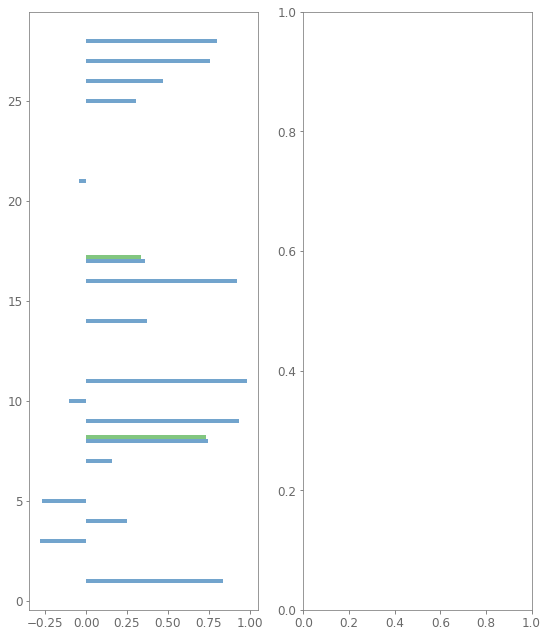

In [17]:
# plot metrics


# combine metrics in dict
#metrics_all_dict = {'KGE':kge_dict, 'R':r_dict,'alpha':alpha_dict, 'beta': beta_dict}
metrics_all_dict = {'KGE':kge_dict}

metric_names = {'KGE':'KGE', 'R':'correlation (r)','alpha':'variability bias ($\sigma_{mod}$/$\sigma_{obs})$', 'beta':' mean bias ($\mu_{mod}$/$\mu_{obs}$)'}
# initialise figure
fig, axes = plt.subplots(1,2, figsize=(9,11))

# sort data
metric = 'KGE'
metric_dict = metrics_all_dict[metric]

# irrigation reservoirs
reservoir_subset = list(names)

for n,variable in enumerate(['outflow','storage']):


    cases_toplot = cases[:-1]

    if variable =='storage':
        cases_toplot = cases_toplot[1:]
        colors_toplot = colors[1:]
    else: 
        colors_toplot = colors

    scores = np.empty((len(cases_toplot),len(reservoir_subset)))
    reservoir_subset = list(names)
    reservoir_subset.reverse()

    for i,reservoir in enumerate(reservoir_subset):
        res_scores = []
        for case in cases_toplot: 
            res_scores.append(metric_dict[reservoir][case][variable].squeeze())
        scores[:,i] = np.array(res_scores)
  
    barWidth = 0.2  
    # Set position of bar on X axis
    barpositions = np.empty((len(cases_toplot),len(reservoir_subset)))
    barpositions[0,:] = np.arange(len(scores[0,:]))

    for i in range(1,barpositions.shape[0]):
        barpositions[i,:] =  [x + barWidth for x in barpositions[i-1,:] ]  
    ax = axes[n]

    for i,score in enumerate(scores):  
        ax.barh(barpositions[i,:], score,height = barWidth, label=cases_longname[i], color=colors_toplot[i], alpha=0.7)
    reservoir_subset_names = [names_dict[k] for k in reservoir_subset] 
    ax.set_yticks([r + barWidth for r in range(len(barpositions[0,:]))])
    ax.set_yticklabels(reservoir_subset_names)
    ax.set_title(metric_names[metric]+' '+variable,loc='right', fontsize=16)
    ax.axvline(0, linewidth=0.8, color='lightgray')
    ax.axvline(-0.41, linewidth=0.8, color='lightgray', alpha=0.5, linestyle='--')

    ax.set_xlim([-1,1])
    ax.set_xlabel('[-]')
    ax.text(0, 1.01, panel_labels[n], color='dimgrey', fontsize=14, transform=ax.transAxes );
    
    ax.annotate('', xy=(0.25,-0.07), xycoords=("axes fraction"), xytext=(1,-0.07), arrowprops=dict(arrowstyle="<-", color="gray",linewidth=1.5));
    ax.annotate('Higher skill', xy=(0.65,-0.1), xycoords=("axes fraction"), xytext=(0.65,-0.1), fontsize=14, color="gray",style='italic'); 
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles[::-1], labels[::-1], fontsize=11, loc="upper left");



fig.tight_layout()
#fig.suptitle('Irrigation reservoirs', fontsize=16,x=0.1, y= 1.01); 
#fig.text(0.04, 1.01, 'Irrigation reservoirs', fontsize=16, fontstyle='normal'); 
#fig.text(0.55, 1.01, 'Non-irrigation reservoirs', fontsize=16, fontstyle='normal'); 
fig.savefig(scriptsdir+'plots/resobs_clm/kge'+monthly_fn+'_resobs.png', bbox_inches="tight")


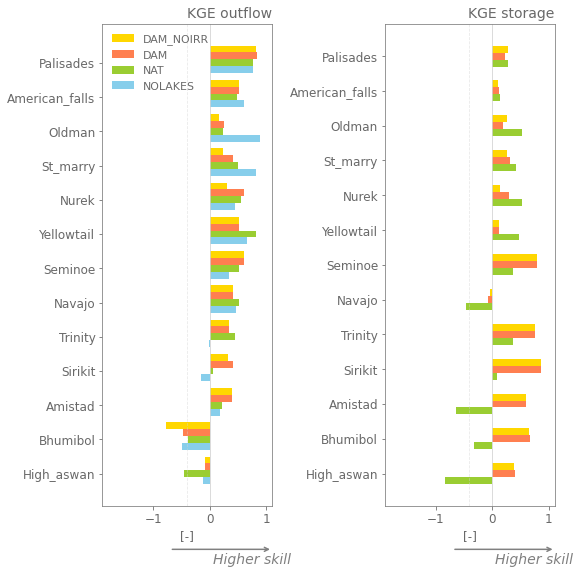

In [15]:
# plot metrics


# combine metrics in dict
#metrics_all_dict = {'KGE':kge_dict, 'R':r_dict,'alpha':alpha_dict, 'beta': beta_dict}
metrics_all_dict = {'KGE':kge_dict}

metric_names = {'KGE':'KGE', 'R':'correlation (r)','alpha':'variability bias ($\sigma_{mod}$/$\sigma_{obs})$', 'beta':' mean bias ($\mu_{mod}$/$\mu_{obs}$)'}
# initialise figure
fig, axes = plt.subplots(1,2, figsize=(8,8))

# sort data
metric = 'KGE'
metric_dict = metrics_all_dict[metric]

reservoir_subset = list(names_irrig_all)

# irrigation reservoirs

for n,variable in enumerate(['outflow','storage']):

    cases_toplot  = cases



    if variable =='storage':
        cases_toplot = cases_toplot[1:]
        colors_toplot = colors[1:]
    else: 
        colors_toplot = colors

    scores = np.empty((len(cases_toplot),len(reservoir_subset)))
    reservoir_subset = list(names_irrig_all)
    reservoir_subset.reverse()
    for i,reservoir in enumerate(reservoir_subset):
        res_scores = []
        for case in cases_toplot: 
            res_scores.append(metric_dict[reservoir][case][variable].squeeze())
        scores[:,i] = np.array(res_scores)


    barWidth = 0.2  

    # Set position of bar on X axis
    barpositions = np.empty((len(cases_toplot),len(reservoir_subset)))
    barpositions[0,:] = np.arange(len(scores[0,:]))

    for i in range(1,barpositions.shape[0]):
        barpositions[i,:] =  [x + barWidth for x in barpositions[i-1,:] ]  

    ax = axes[n]
    ax.axvline(-0.41, linewidth=0.8, color='lightgray', alpha=0.5, linestyle='--')

    for i,score in enumerate(scores):  
        ax.barh(barpositions[i,:], score,height = barWidth, label=cases_longname[i], color=colors_toplot[i])
    reservoir_subset_names = [names_dict[k] for k in reservoir_subset] 

    ax.set_yticks([r + barWidth for r in range(len(barpositions[0,:]))])
    ax.set_yticklabels(reservoir_subset)
    ax.set_title(metric_names[metric]+' '+variable,loc='right', fontsize=14)
    ax.axvline(0, linewidth=0.8, color='lightgray')

    ax.set_xlim([-1.9,1.1])
    ax.set_xlabel('[-]')
    
    ax.annotate('', xy=(0.4,-0.09), xycoords=("axes fraction"), xytext=(1,-0.09), arrowprops=dict(arrowstyle="<-", color="gray",linewidth=1.5));
    ax.annotate('Higher skill', xy=(0.65,-0.12), xycoords=("axes fraction"), xytext=(0.65,-0.12), fontsize=14, color="gray",style='italic'); 
    
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles[::-1], labels[::-1], fontsize=11, loc="upper left");

fig.tight_layout()
#fig.suptitle('Irrigation reservoirs', fontsize=16,x=0.1, y= 1.01); 
#fig.text(0.04, 1.01, 'Irrigation reservoirs', fontsize=16, fontstyle='normal'); 
#fig.text(0.55, 1.01, 'Non-irrigation reservoirs', fontsize=16, fontstyle='normal'); 
fig.savefig(scriptsdir+'plots/resobs_clm/kge_irrig'+monthly_fn+'_resobs.png', bbox_inches="tight")


## Values for paper

In [11]:
metrics_all_dict = {'KGE':kge_dict}

for variable in ['outflow', 'storage']: 
    print(variable)
    
    for metric in ['KGE']:
        print(metric)
        metric_dict = metrics_all_dict[metric]
        for case in cases: 
            res_scores = []
            for reservoir in list(metrics_all_dict[metric].keys()): 
                
                res_scores.append(metric_dict[reservoir][case][variable].squeeze())
            print(case+' median '+ str(np.round(np.median(res_scores),2) ))
        print('')
    print('')   

outflow
KGE
nolake median 0.38
natlake median 0.49
H06 median 0.45
H06_noirrig median 0.42


storage
KGE
nolake median nan
natlake median 0.08
H06 median 0.4
H06_noirrig median 0.39




## Other plots

NameError: name 'ntopo_res_orig' is not defined

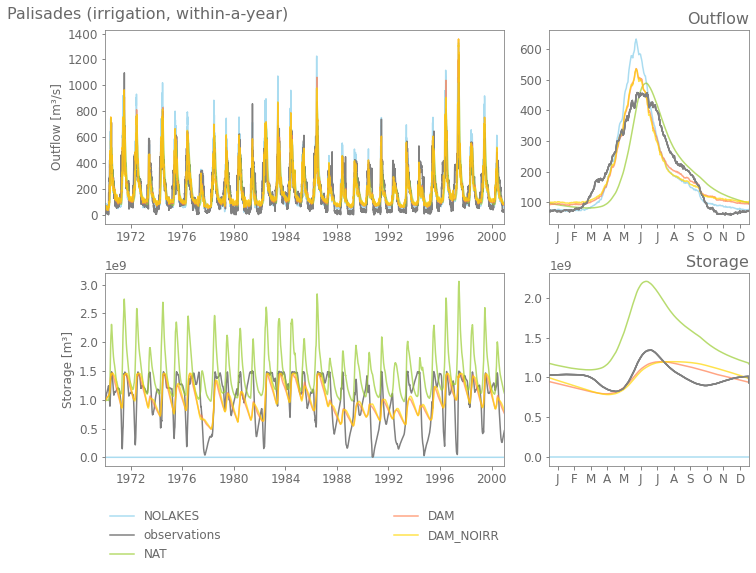

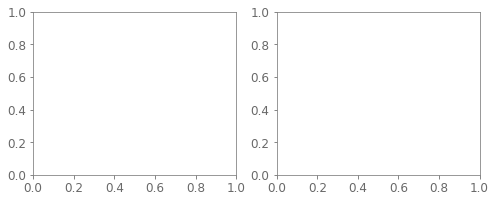

In [6]:
# plot timeseries per reservoir 
flag_plot_demand  = True
names = names_sorted
for reservoir_name in names['name'].values:
    
    df_res_dict = df_mod_dict[reservoir_name]
    


    res_pfaf = df_meta.loc[df_meta['name']==reservoir_name,'pfaf_hdma_10km']
    ntopo_res = ntopo.where(ntopo.PFAF.astype(float) == res_pfaf.values, drop=True)


    # only plot for irrigation reservoirs
    if res_info[reservoir_name]['purpose'] == 'irrigation': 

        ########
        # do plotting
        fig, axes = plt.subplots(2,2, figsize = (10,8), gridspec_kw={
                               'width_ratios': [2, 1],
                               'height_ratios': [1, 1]})
        for n,variable in enumerate( ['outflow','storage']):
            for j, case in enumerate(cases):                      

                 #if not (res_info[reservoir_name]['purpose']=='non-irrigation' and case == 'H06_noirrig'):


                df = pd.read_csv(scriptsdir+'results_resobs_pythoncode/'+reservoir_name+'_'+case+monthly_fn+'.csv')
                df.index = df['time']
                df.index = pd.to_datetime(df.index)
                # determine timestep of observations (to account for monthly)
                timestep = 'daily' if (df.index[1]).day - (df.index[0]).day == 1 else 'monthly'

                # plot timeseries
                axes[n][0].plot(df_res_dict[case].index,df_res_dict[case][variable], alpha=0.7,label=cases_longname[cases.index(case)], color=colors[j])

                # plot obs only once (not for every case)
                if j == 0: axes[n][0].plot(df.index, df[variable+'_observed'], color="gray", label = "observations")

                if variable == 'storage': 
                    ylabel = 'Storage [m³]'
                elif variable == 'inflow' :
                    ylabel  =  'Inflow [m³/s]'
                else: ylabel='Outflow [m³/s]'

                axes[n][0].set_ylabel(ylabel); 
                axes[n][0].set_xlim([df_res_dict[case].index.min(),df_res_dict[case].index.max()]); 

                import matplotlib.dates as mdates
                myFmt = mdates.DateFormatter('%Y')
                axes[n][0].xaxis.set_major_formatter(myFmt)
                #axes[n][0].grid()

                # plot seasonal cycle 
                if timestep == 'daily': 
                    df_res_seasonal = df_res_dict[case][variable].groupby(df_res_dict[case][variable].index.dayofyear).mean()
                    df_obs_seasonal = df[variable+'_observed'].groupby(df[variable+'_observed'].index.dayofyear).mean()

                    axes[n][1].set_xticks(np.linspace(15,380,13)[:-1])
                    axes[n][1].set_xlim([0,366])
                elif timestep == 'monthly': 
                    df_res_seasonal = df_res_dict[case][variable].groupby(df_res_dict[case][variable].index.month).mean()
                    df_obs_seasonal = df[variable+'_observed'].groupby(df[variable+'_observed'].index.month).mean()
                    axes[n][1].set_xticks(np.linspace(1.5,12.5,12))
                    axes[n][1].set_xlim([1,12])

                axes[n][1].plot(df_res_seasonal.index,df_res_seasonal, alpha=0.7,label=cases_longname[cases.index(case)], color=colors[j])
                axes[n][1].plot(df_obs_seasonal.index, df_obs_seasonal, color="gray", label = "observations")
                axes[n][1].set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
                axes[n][1].set_title(variable.title(), loc='right'); 

                #axes[n][1].grid()


        axes[n][0].legend(bbox_to_anchor=(-0, -0.05, 1., -0.152), loc='upper left',
               ncol=2, mode="expand", borderaxespad=0.); 

        fig.suptitle(reservoir_name + ' ('+res_info[reservoir_name]['purpose']+ ', '+res_info[reservoir_name]['size']+')', fontsize=16,x=0.15, y= 0.99)
        fig.tight_layout()
        fig.savefig(scriptsdir+'plots/resobs_clm/'+reservoir_name+'.png')

        if res_info[reservoir_name]['purpose'] == 'irrigation' and flag_plot_demand: 
            fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,3))
            demand_seas = []
            for month in months: demand_seas.append(ntopo_res['H06_D_'+month].values[0])
            demand_seas_orig = []
            for month in months: demand_seas_orig.append(ntopo_res_orig['H06_D_'+month].values[0])
            
            ax1.plot(np.arange(0,12), demand_seas, label = 'scaled')
            ax1.plot(np.arange(0,12),demand_seas_orig, label='original')
            ax1.legend()
            ax1.set_xticks(np.arange(0,12))
            ax1.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
            ax1.set_xlim([0,11])
            ax1.set_title('Prescribed demand seasonality', loc='right', fontsize=14)
            ax1.set_ylabel('[m³/s]')

            ax2.plot(np.arange(0,12), df['inflow'].groupby(df['inflow'].index.month).mean())
            ax2.set_xticks(np.arange(0,12))
            ax2.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
            ax2.set_xlim([0,11])
            ax2.set_title('Prescribed inflow seasonality', loc='right', fontsize=14)
            ax2.set_ylabel('[m³/s]')
            fig.tight_layout()
            fig.savefig(scriptsdir+'results_resobs_pythoncode/plots/'+reservoir_name+monthly_fn+'.png')

In [ ]:
# plot metrics


reservoir_subset = names_irrig
# combine metrics in dict
#metrics_all_dict = {'KGE':kge_dict, 'R':r_dict,'alpha':alpha_dict, 'beta': beta_dict}
metrics_all_dict = {'KGE':kge_dict}

metric_names = {'KGE':'KGE', 'R':'correlation (r)','alpha':'variability bias ($\sigma_{mod}$/$\sigma_{obs})$', 'beta':' mean bias ($\mu_{mod}$/$\mu_{obs}$)'}
# initialise figure
fig, axes = plt.subplots(1,4, figsize=(16,8))

# sort data
metric = 'KGE'
metric_dict = metrics_all_dict[metric]

# irrigation reservoirs

for k, reservoir_subset in enumerate([list(names_irrig),names_nonirrig]):
    for n,variable in enumerate(['outflow','storage']):

        if k == 0: 
            cases_toplot  = cases
        
        else: 
            cases_toplot = cases[:-1]
            
        if variable =='storage':
            cases_toplot = cases_toplot[1:]
            colors_toplot = colors[1:]
        else: 
            colors_toplot = colors
            
        scores = np.empty((len(cases_toplot),len(reservoir_subset)))

        for i,reservoir in enumerate(reservoir_subset):
            res_scores = []
            for case in cases_toplot: 
                res_scores.append(metric_dict[reservoir][case][variable].squeeze())
            scores[:,i] = np.array(res_scores)


        barWidth = 0.2  

        # Set position of bar on X axis
        barpositions = np.empty((len(cases_toplot),len(reservoir_subset)))
        barpositions[0,:] = np.arange(len(scores[0,:]))

        for i in range(1,barpositions.shape[0]):
            barpositions[i,:] =  [x + barWidth for x in barpositions[i-1,:] ]  
        if k == 0: 
            ax = axes[n]
        else: 
            ax = axes[2+n]
        for i,score in enumerate(scores):  
            ax.barh(barpositions[i,:], score,height = barWidth, label=cases_longname[i], color=colors_toplot[i])

        ax.set_yticks([r + barWidth for r in range(len(barpositions[0,:]))])
        ax.set_yticklabels(reservoir_subset)
        ax.set_title(metric_names[metric]+' '+variable,loc='right', fontsize=14)
        ax.axvline(0, linewidth=0.8, color='lightgray')
        ax.set_xlim([-1.9,1.1])
        ax.set_xlabel('[-]')
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles[::-1], labels[::-1], fontsize=11, loc="lower left");

fig.tight_layout()
#fig.suptitle('Irrigation reservoirs', fontsize=16,x=0.1, y= 1.01); 
fig.text(0.04, 1.01, 'Irrigation reservoirs', fontsize=16, fontstyle='normal'); 
fig.text(0.55, 1.01, 'Non-irrigation reservoirs', fontsize=16, fontstyle='normal'); 
fig.savefig(scriptsdir+'plots/resobs_clm/kge'+monthly_fn+'_resobs.png', bbox_inches="tight")


In [ ]:
# plot timeseries per variable for all irrigation reservoirs
irrig_res_names = df_meta.loc[df_meta['purpose']=='irrigation','name']
names_irrig = set(names).intersection(irrig_res_names)

fig, axes = plt.subplots(len(names_nonirrig),2, figsize = (9,16), gridspec_kw={
                               'width_ratios': [2, 1]})
variable='outflow'
for n,reservoir_name in enumerate(names_nonirrig):
    
    df_res_dict = df_mod_dict[reservoir_name]
    
    # determine timestep of observations (to account for monthly)
    timestep = 'daily' if (df.index[1]).day - (df.index[0]).day == 1 else 'monthly'

    res_pfaf = df_meta.loc[df_meta['name']==reservoir_name,'pfaf_hdma_10km']
    ntopo_res = ntopo.where(ntopo.PFAF.astype(float) == res_pfaf.values, drop=True)

    # only plot for irrigation reservoirs

    ########
    # do plotting

    for j, case in enumerate(cases):                      

        if not (res_info[reservoir_name]['purpose']=='non-irrigation' and case == 'H06_noirrig'):


            df = pd.read_csv(scriptsdir+'results_resobs_pythoncode/'+reservoir_name+'_'+case+'.csv')
            df.index = df['time']
            df.index = pd.to_datetime(df.index)

            # plot timeseries
            axes[n][0].plot(df_res_dict[case].index,df_res_dict[case][variable], alpha=0.7,label=cases_longname[cases.index(case)], color=colors[j])

            # plot obs only once (not for every case)
            if j == 0: axes[n][0].plot(df.index, df[variable+'_observed'], color="gray", label = "observations")

            if variable == 'storage': 
                ylabel = 'Storage [m³]'
            elif variable == 'inflow' :
                ylabel  =  'Inflow [m³/s]'
            else: ylabel='Outflow [m³/s]'

            axes[n][0].set_ylabel(ylabel); 
            axes[n][0].set_xlim([df_res_dict[case].index.min(),df_res_dict[case].index.max()]); 

            import matplotlib.dates as mdates
            myFmt = mdates.DateFormatter('%Y')
            axes[n][0].xaxis.set_major_formatter(myFmt)

            #axes[n][0].grid()

            # plot seasonal cycle 
            if timestep == 'daily': 
                df_res_seasonal = df_res_dict[case][variable].groupby(df_res_dict[case][variable].index.dayofyear).mean()
                df_obs_seasonal = df[variable+'_observed'].groupby(df[variable+'_observed'].index.dayofyear).mean()

                axes[n][1].set_xticks(np.linspace(15,380,13)[:-1])
                axes[n][1].set_xlim([0,366])
            elif timestep == 'monthly': 
                df_res_seasonal = df_res_dict[case][variable].groupby(df_res_dict[case][variable].index.month).mean()
                df_obs_seasonal = df[variable+'_observed'].groupby(df[variable+'_observed'].index.month).mean()
                axes[n][1].set_xticks(np.linspace(1.5,12.5,12))
                axes[n][1].set_xlim([1,12])

            axes[n][1].plot(df_res_seasonal.index,df_res_seasonal, alpha=0.7,label=cases_longname[cases.index(case)], color=colors[j])
            axes[n][1].plot(df_obs_seasonal.index, df_obs_seasonal, color="gray", label = "observations")
            axes[n][1].set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
            axes[n][0].set_title(reservoir_name + ' ('+res_info[reservoir_name]['size']+')', loc='right', size=14); 

    handles, labels = axes[0][0].get_legend_handles_labels()

    order = [0,2,3,4,1]
    #axes[len(names_nonirrig)-1][0].legend([handles[idx] for idx in order],[labels[idx] for idx in order],bbox_to_anchor=(-0, -0.05, 1., -0.152),mode='expand', ncol=3,fontsize=11, borderaxespad=0.); 

            #axes[n][1].grid()


    #axes[n][0].legend(bbox_to_anchor=(-0, -0.05, 1., -0.152), loc='upper left', ncol=2, mode="expand", borderaxespad=0.); 

    #fig.suptitle(variable, fontsize=16,x=0.15, y= 0.99)
    fig.tight_layout()
    #fig.savefig(scriptsdir+'plots/resobs_clm/'+reservoir_name+'.png')


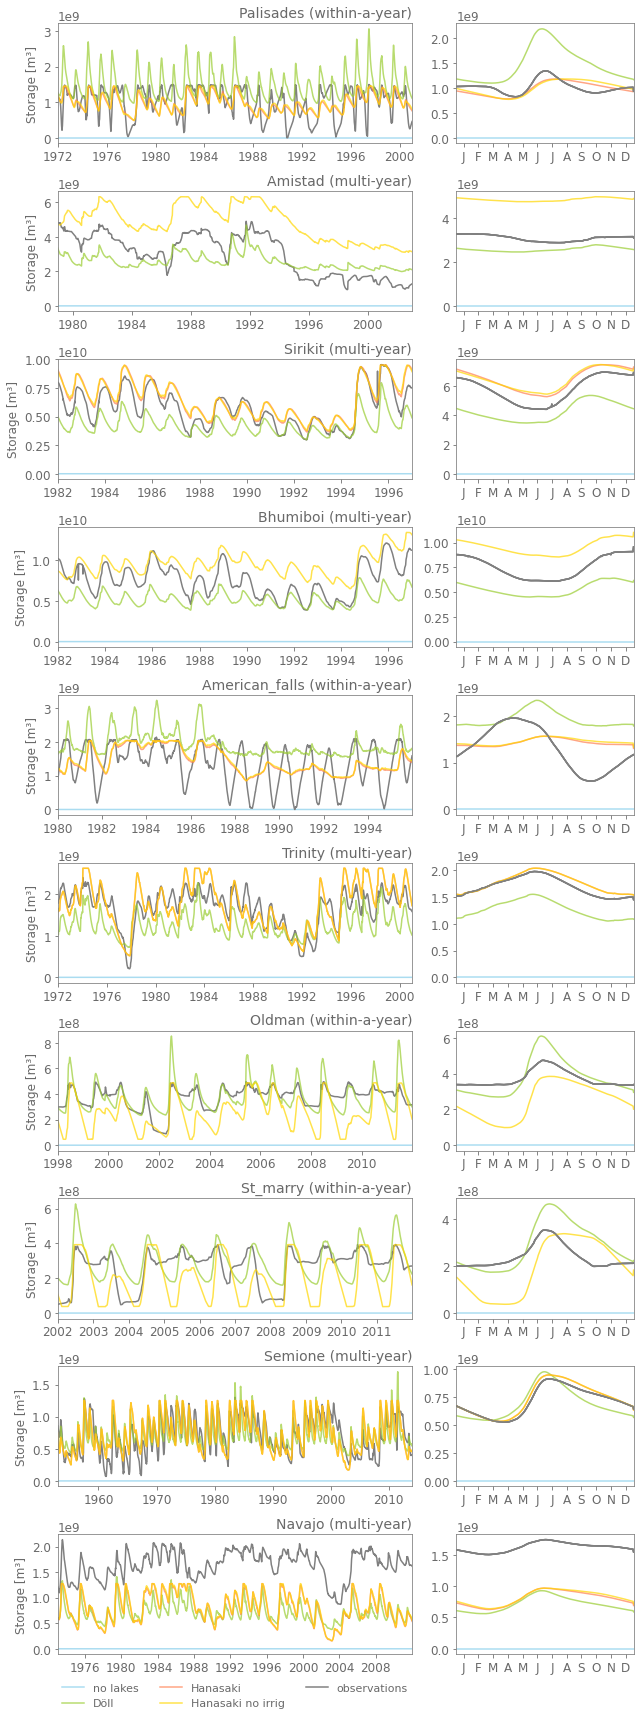

In [9]:
# plot timeseries per variable for all irrigation reservoirs
flag_plot_demand  = True
irrig_res_names = df_meta.loc[df_meta['purpose']=='irrigation','name']
names_irrig = set(names).intersection(irrig_res_names)

fig, axes = plt.subplots(len(names_irrig),2, figsize = (9,24), gridspec_kw={
                               'width_ratios': [2, 1]})

variable='storage'
for n,reservoir_name in enumerate(names_irrig):
    
    df_res_dict = df_mod_dict[reservoir_name]
    
    # determine timestep of observations (to account for monthly)
    timestep = 'daily' if (df.index[1]).day - (df.index[0]).day == 1 else 'monthly'

    res_pfaf = df_meta.loc[df_meta['name']==reservoir_name,'pfaf_hdma_10km']
    ntopo_res = ntopo.where(ntopo.PFAF.astype(float) == res_pfaf.values, drop=True)

    # only plot for irrigation reservoirs

    ########
    # do plotting

    for j, case in enumerate(cases):                      

        if not (res_info[reservoir_name]['purpose']=='non-irrigation' and case == 'H06_noirrig'):


            df = pd.read_csv(scriptsdir+'results_resobs_pythoncode/'+reservoir_name+'_'+case+'.csv')
            df.index = df['time']
            df.index = pd.to_datetime(df.index)

            # plot timeseries
            axes[n][0].plot(df_res_dict[case].index,df_res_dict[case][variable], alpha=0.7,label=cases_longname[cases.index(case)], color=colors[j])

            # plot obs only once (not for every case)
            if j == 0: axes[n][0].plot(df.index, df[variable+'_observed'], color="gray", label = "observations")

            if variable == 'storage': 
                ylabel = 'Storage [m³]'
            elif variable == 'inflow' :
                ylabel  =  'Inflow [m³/s]'
            else: ylabel='Outflow [m³/s]'

            axes[n][0].set_ylabel(ylabel); 
            axes[n][0].set_xlim([df_res_dict[case].index.min(),df_res_dict[case].index.max()]); 

            import matplotlib.dates as mdates
            myFmt = mdates.DateFormatter('%Y')
            axes[n][0].xaxis.set_major_formatter(myFmt)

            #axes[n][0].grid()

            # plot seasonal cycle 
            if timestep == 'daily': 
                df_res_seasonal = df_res_dict[case][variable].groupby(df_res_dict[case][variable].index.dayofyear).mean()
                df_obs_seasonal = df[variable+'_observed'].groupby(df[variable+'_observed'].index.dayofyear).mean()

                axes[n][1].set_xticks(np.linspace(15,380,13)[:-1])
                axes[n][1].set_xlim([0,366])
            elif timestep == 'monthly': 
                df_res_seasonal = df_res_dict[case][variable].groupby(df_res_dict[case][variable].index.month).mean()
                df_obs_seasonal = df[variable+'_observed'].groupby(df[variable+'_observed'].index.month).mean()
                axes[n][1].set_xticks(np.linspace(1.5,12.5,12))
                axes[n][1].set_xlim([1,12])

            axes[n][1].plot(df_res_seasonal.index,df_res_seasonal, alpha=0.7,label=cases_longname[cases.index(case)], color=colors[j])
            axes[n][1].plot(df_obs_seasonal.index, df_obs_seasonal, color="gray", label = "observations")
            axes[n][1].set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
            axes[n][0].set_title(reservoir_name + ' ('+res_info[reservoir_name]['size']+')', loc='right', size=14); 

    handles, labels = axes[0][0].get_legend_handles_labels()

    order = [0,2,3,4,1]
    axes[len(names_irrig)-1][0].legend([handles[idx] for idx in order],[labels[idx] for idx in order],bbox_to_anchor=(-0, -0.05, 1., -0.152),mode='expand', ncol=3,fontsize=11, borderaxespad=0.); 

            #axes[n][1].grid()


    #axes[n][0].legend( loc='upper left', ncol=2, mode="expand", borderaxespad=0.); 

    #fig.suptitle(variable, fontsize=16,x=0.15, y= 0.99)
    fig.tight_layout()
    #fig.savefig(scriptsdir+'plots/resobs_clm/'+reservoir_name+'.png')


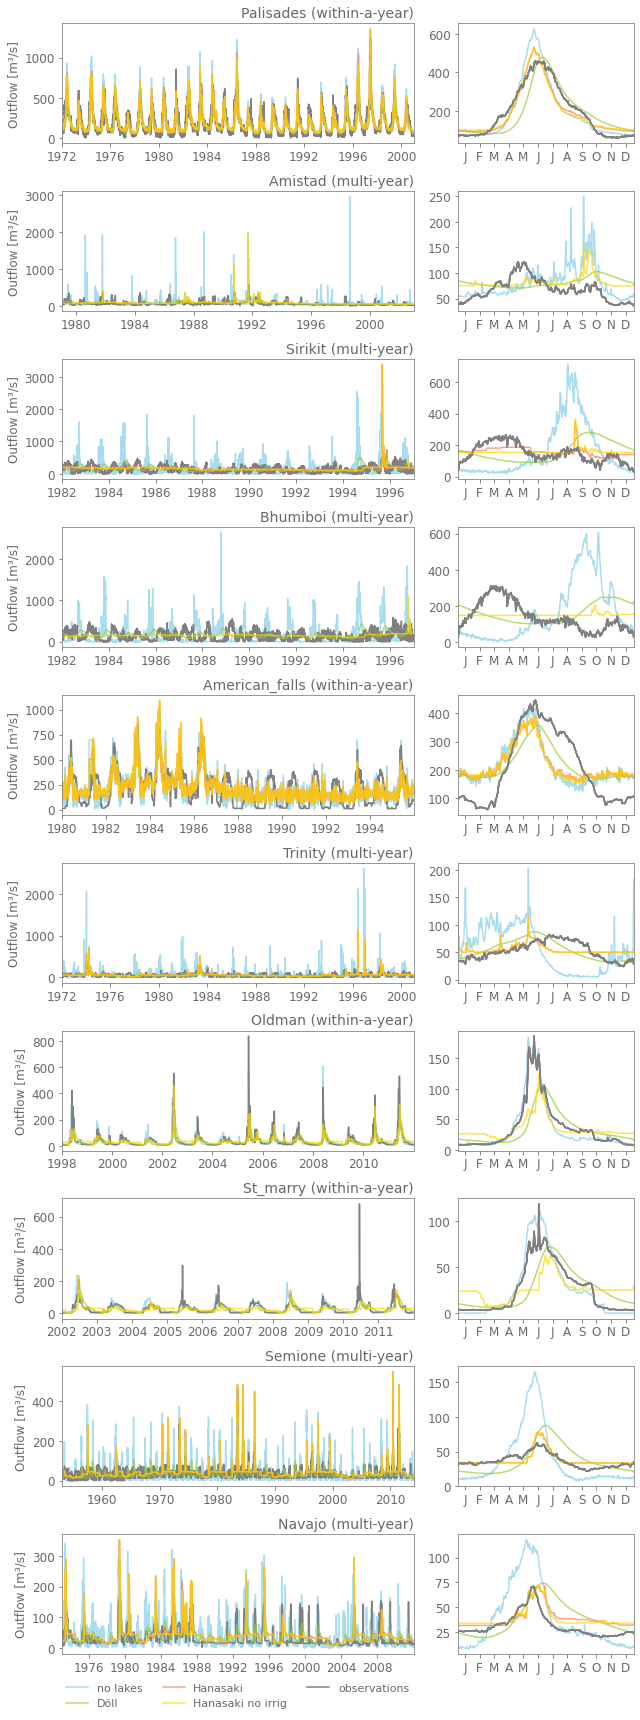

In [10]:
# plot timeseries per variable for all irrigation reservoirs
flag_plot_demand  = True
irrig_res_names = df_meta.loc[df_meta['purpose']=='irrigation','name']
names_irrig = set(names).intersection(irrig_res_names)

fig, axes = plt.subplots(len(names_irrig),2, figsize = (9,24), gridspec_kw={
                               'width_ratios': [2, 1]})
variable='outflow'
for n,reservoir_name in enumerate(names_irrig):
    
    df_res_dict = df_mod_dict[reservoir_name]
    
    # determine timestep of observations (to account for monthly)
    timestep = 'daily' if (df.index[1]).day - (df.index[0]).day == 1 else 'monthly'

    res_pfaf = df_meta.loc[df_meta['name']==reservoir_name,'pfaf_hdma_10km']
    ntopo_res = ntopo.where(ntopo.PFAF.astype(float) == res_pfaf.values, drop=True)

    # only plot for irrigation reservoirs

    ########
    # do plotting

    for j, case in enumerate(cases):                      

        if not (res_info[reservoir_name]['purpose']=='non-irrigation' and case == 'H06_noirrig'):


            df = pd.read_csv(scriptsdir+'results_resobs_pythoncode/'+reservoir_name+'_'+case+'.csv')
            df.index = df['time']
            df.index = pd.to_datetime(df.index)

            # plot timeseries
            axes[n][0].plot(df_res_dict[case].index,df_res_dict[case][variable], alpha=0.7,label=cases_longname[cases.index(case)], color=colors[j])

            # plot obs only once (not for every case)
            if j == 0: axes[n][0].plot(df.index, df[variable+'_observed'], color="gray", label = "observations")

            if variable == 'storage': 
                ylabel = 'Storage [m³]'
            elif variable == 'inflow' :
                ylabel  =  'Inflow [m³/s]'
            else: ylabel='Outflow [m³/s]'

            axes[n][0].set_ylabel(ylabel); 
            axes[n][0].set_xlim([df_res_dict[case].index.min(),df_res_dict[case].index.max()]); 

            import matplotlib.dates as mdates
            myFmt = mdates.DateFormatter('%Y')
            axes[n][0].xaxis.set_major_formatter(myFmt)

            #axes[n][0].grid()

            # plot seasonal cycle 
            if timestep == 'daily': 
                df_res_seasonal = df_res_dict[case][variable].groupby(df_res_dict[case][variable].index.dayofyear).mean()
                df_obs_seasonal = df[variable+'_observed'].groupby(df[variable+'_observed'].index.dayofyear).mean()

                axes[n][1].set_xticks(np.linspace(15,380,13)[:-1])
                axes[n][1].set_xlim([0,366])
            elif timestep == 'monthly': 
                df_res_seasonal = df_res_dict[case][variable].groupby(df_res_dict[case][variable].index.month).mean()
                df_obs_seasonal = df[variable+'_observed'].groupby(df[variable+'_observed'].index.month).mean()
                axes[n][1].set_xticks(np.linspace(1.5,12.5,12))
                axes[n][1].set_xlim([1,12])

            axes[n][1].plot(df_res_seasonal.index,df_res_seasonal, alpha=0.7,label=cases_longname[cases.index(case)], color=colors[j])
            axes[n][1].plot(df_obs_seasonal.index, df_obs_seasonal, color="gray", label = "observations")
            axes[n][1].set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
            axes[n][0].set_title(reservoir_name + ' ('+res_info[reservoir_name]['size']+')', loc='right', size=14); 

    handles, labels = axes[0][0].get_legend_handles_labels()

    order = [0,2,3,4,1]
    axes[len(names_irrig)-1][0].legend([handles[idx] for idx in order],[labels[idx] for idx in order],bbox_to_anchor=(-0, -0.05, 1., -0.152),mode='expand', ncol=3,fontsize=11, borderaxespad=0.); 

            #axes[n][1].grid()


    #axes[n][0].legend(bbox_to_anchor=(-0, -0.05, 1., -0.152), loc='upper left', ncol=2, mode="expand", borderaxespad=0.); 

    #fig.suptitle(variable, fontsize=16,x=0.15, y= 0.99)
    fig.tight_layout()
    #fig.savefig(scriptsdir+'plots/resobs_clm/'+reservoir_name+'.png')


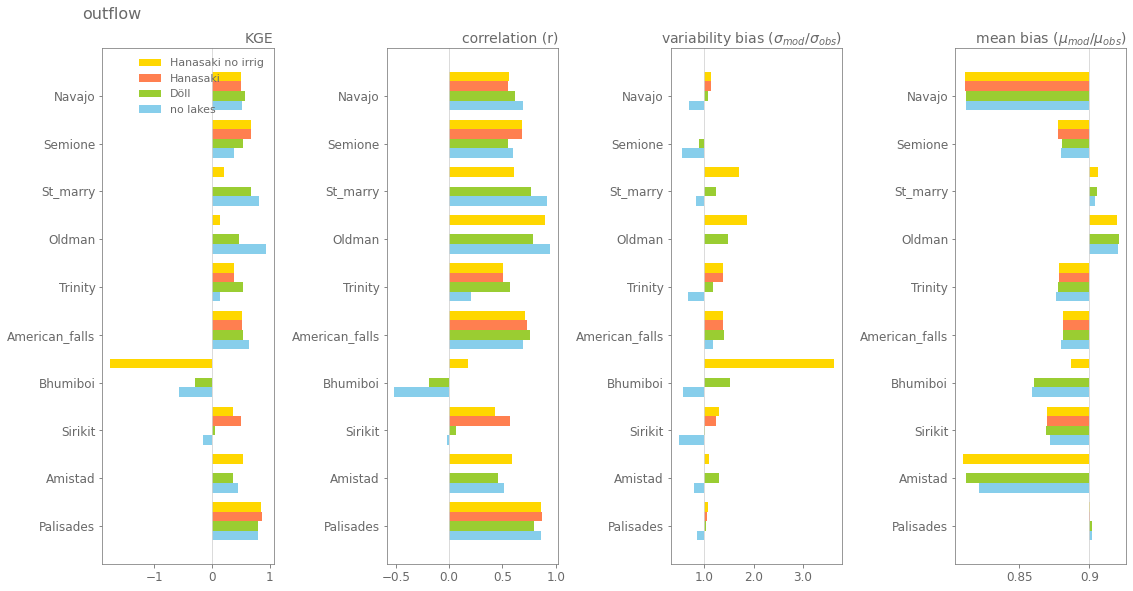

In [11]:
# plot metrics
variable = 'outflow'

reservoir_subset = names_irrig
# combine metrics in dict
metrics_all_dict = {'KGE':kge_dict, 'R':r_dict,'alpha':alpha_dict, 'beta': beta_dict}

metric_names = {'KGE':'KGE', 'R':'correlation (r)','alpha':'variability bias ($\sigma_{mod}$/$\sigma_{obs})$', 'beta':' mean bias ($\mu_{mod}$/$\mu_{obs}$)'}
# initialise figure
fig, axes = plt.subplots(1,4, figsize=(16,8))

# sort data
for n,metric in enumerate(metrics_all_dict.keys()): 
    metric_dict = metrics_all_dict[metric]
    
    scores = np.empty((len(cases),len(reservoir_subset)))
    
    for i,reservoir in enumerate(reservoir_subset):
        res_scores = []
        for case in metric_dict[reservoir].keys(): 
            res_scores.append(metric_dict[reservoir][case][variable].squeeze())
        scores[:,i] = np.array(res_scores)

        
    if metric == 'alpha' or metric == 'beta': # 1 is best value, let them center around 0 and adjust tick labels. 
        scores = scores-1
    
    x_labels = metric_dict.keys

    barWidth = 0.2  

    # Set position of bar on X axis
    barpositions = np.empty((len(cases),len(reservoir_subset)))
    barpositions[0,:] = np.arange(len(scores[0,:]))

    for i in range(1,barpositions.shape[0]):
        barpositions[i,:] =  [x + barWidth for x in barpositions[i-1,:] ]  

    ax = axes[n]
    for i,score in enumerate(scores):  
        ax.barh(barpositions[i,:], score,height = barWidth, label=cases_longname[i], color=colors[i])

    if metric == 'alpha' or metric == 'beta': # 1 is best value, let them center around 0 and adjust tick labels.  
        xticks = ax.get_xticks()
        ax.set_xticklabels(xticks+1)
    
    ax.set_yticks([r + barWidth for r in range(len(barpositions[0,:]))])
    ax.set_yticklabels(reservoir_subset)
    ax.set_title(metric_names[metric],loc='right', fontsize=14)
    ax.axvline(0, linewidth=0.8, color='lightgray')
    #if n < 2 : ax.invert_xaxis()
    if n==0: 
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[::-1], labels[::-1], fontsize=11);

fig.tight_layout()
fig.suptitle(variable, fontsize=16,x=0.1, y= 1.02); 



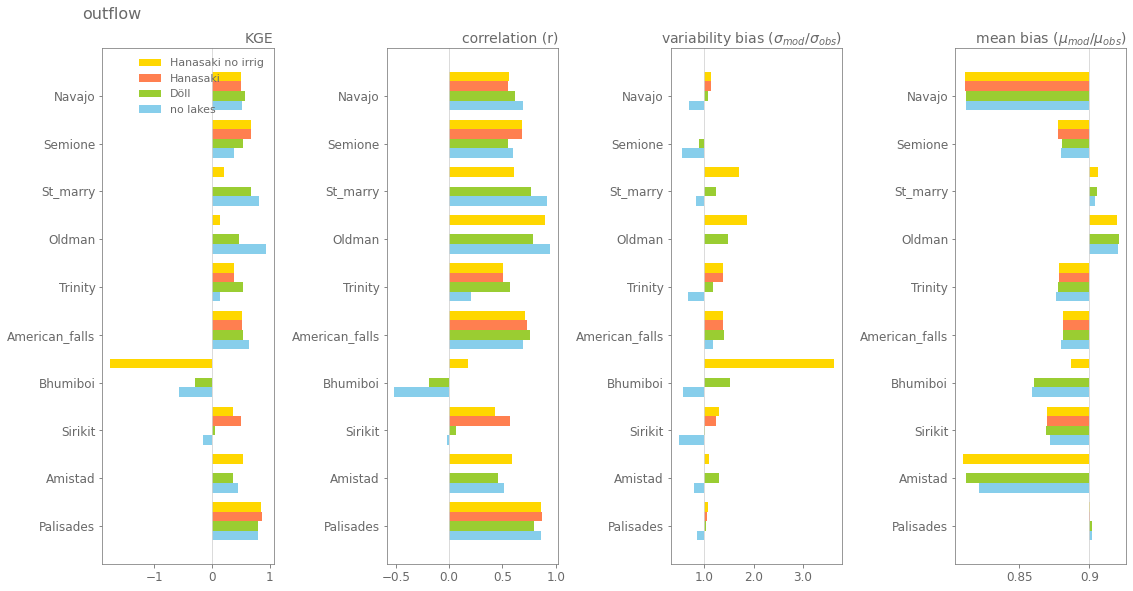

In [12]:
# plot metrics - based on monthly calculations
variable = 'outflow'

reservoir_subset = names_irrig
# combine metrics in dict
metrics_all_dict = {'KGE':kge_dict, 'R':r_dict,'alpha':alpha_dict, 'beta': beta_dict}

metric_names = {'KGE':'KGE', 'R':'correlation (r)','alpha':'variability bias ($\sigma_{mod}$/$\sigma_{obs})$', 'beta':' mean bias ($\mu_{mod}$/$\mu_{obs}$)'}
# initialise figure
fig, axes = plt.subplots(1,4, figsize=(16,8))

# sort data
for n,metric in enumerate(metric_names.keys()): 
    metric_dict = metrics_monthly_dict[metric]
    
    scores = np.empty((len(cases),len(reservoir_subset)))
    
    for i,reservoir in enumerate(reservoir_subset):
        res_scores = []
        for case in metric_dict[reservoir].keys(): 
            res_scores.append(metric_dict[reservoir][case][variable].squeeze())
        scores[:,i] = np.array(res_scores)

        
    if metric == 'alpha' or metric == 'beta': # 1 is best value, let them center around 0 and adjust tick labels. 
        scores = scores-1
    
    x_labels = metric_dict.keys

    barWidth = 0.2  

    # Set position of bar on X axis
    barpositions = np.empty((len(cases),len(reservoir_subset)))
    barpositions[0,:] = np.arange(len(scores[0,:]))

    for i in range(1,barpositions.shape[0]):
        barpositions[i,:] =  [x + barWidth for x in barpositions[i-1,:] ]  

    ax = axes[n]
    for i,score in enumerate(scores):  
        ax.barh(barpositions[i,:], score,height = barWidth, label=cases_longname[i], color=colors[i])

    if metric == 'alpha' or metric == 'beta': # 1 is best value, let them center around 0 and adjust tick labels.  
        xticks = ax.get_xticks()
        ax.set_xticklabels(xticks+1)
    
    ax.set_yticks([r + barWidth for r in range(len(barpositions[0,:]))])
    ax.set_yticklabels(reservoir_subset)
    ax.set_title(metric_names[metric],loc='right', fontsize=14)
    ax.axvline(0, linewidth=0.8, color='lightgray')
    #if n < 2 : ax.invert_xaxis()
    if n==0: 
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[::-1], labels[::-1], fontsize=11);

fig.tight_layout()
fig.suptitle(variable, fontsize=16,x=0.1, y= 1.02); 



In [13]:
# plot metrics
variable = 'outflow'

reservoir_subset = names_noirrig
# combine metrics in dict
metrics_all_dict = {'KGE':kge_dict, 'R':r_dict,'alpha':alpha_dict, 'beta': beta_dict}

metric_names = {'KGE':'KGE', 'R':'correlation (r)','alpha':'variability bias ($\sigma_{mod}$/$\sigma_{obs})$', 'beta':' mean bias ($\mu_{mod}$/$\mu_{obs}$)'}
# initialise figure
fig, axes = plt.subplots(1,4, figsize=(16,8))

# sort data
for n,metric in enumerate(metrics_all_dict.keys()): 
    metric_dict = metrics_all_dict[metric]
    
    scores = np.empty((len(cases),len(reservoir_subset)))
    
    for i,reservoir in enumerate(reservoir_subset):
        res_scores = []
        for case in metric_dict[reservoir].keys(): 
            res_scores.append(metric_dict[reservoir][case][variable].squeeze())
        scores[:,i] = np.array(res_scores)

        
    if metric == 'alpha' or metric == 'beta': # 1 is best value, let them center around 0 and adjust tick labels. 
        scores = scores-1
    
    x_labels = metric_dict.keys

    barWidth = 0.2  

    # Set position of bar on X axis
    barpositions = np.empty((len(cases),len(reservoir_subset)))
    barpositions[0,:] = np.arange(len(scores[0,:]))

    for i in range(1,barpositions.shape[0]):
        barpositions[i,:] =  [x + barWidth for x in barpositions[i-1,:] ]  

    ax = axes[n]
    for i,score in enumerate(scores):  
        ax.barh(barpositions[i,:], score,height = barWidth, label=cases_longname[i], color=colors[i])

    if metric == 'alpha' or metric == 'beta': # 1 is best value, let them center around 0 and adjust tick labels.  
        xticks = ax.get_xticks()
        ax.set_xticklabels(xticks+1)
    
    ax.set_yticks([r + barWidth for r in range(len(barpositions[0,:]))])
    ax.set_yticklabels(reservoir_subset)
    ax.set_title(metric_names[metric],loc='right', fontsize=14)
    ax.axvline(0, linewidth=0.8, color='lightgray')
    #if n < 2 : ax.invert_xaxis()
    if n==0: 
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[::-1], labels[::-1], fontsize=11);

fig.tight_layout()
fig.suptitle(variable, fontsize=16,x=0.1, y= 1.02); 



NameError: name 'names_noirrig' is not defined

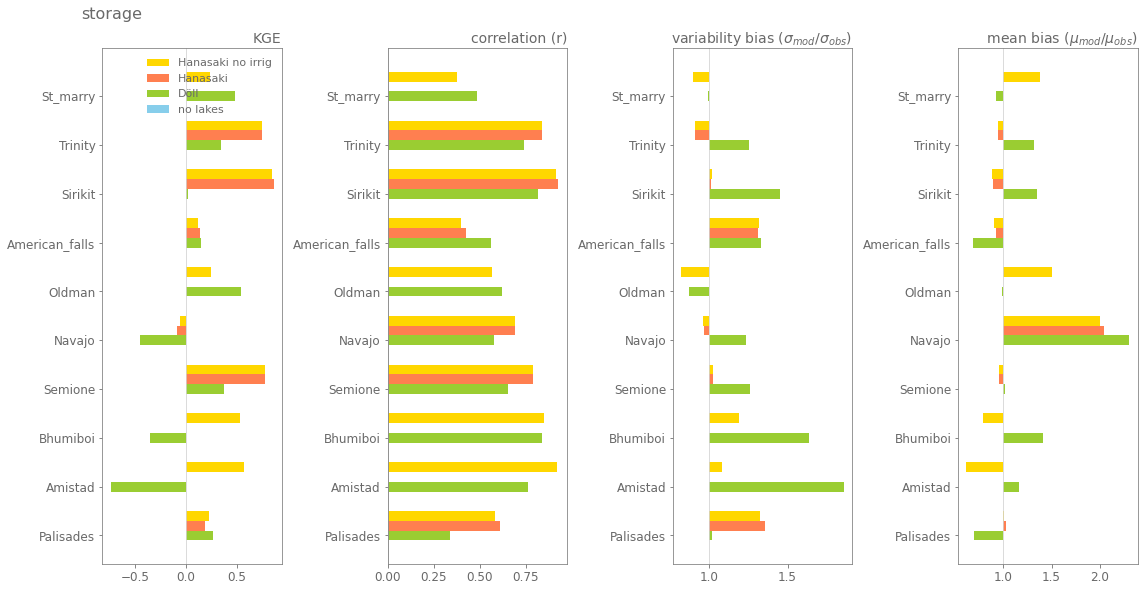

In [15]:
# plot metrics
variable = 'storage'
reservoir_subset = names_irrig
# combine metrics in dict
metrics_all_dict = {'KGE':kge_dict, 'R':r_dict,'alpha':alpha_dict, 'beta': beta_dict}

metric_names = {'KGE':'KGE', 'R':'correlation (r)','alpha':'variability bias ($\sigma_{mod}$/$\sigma_{obs})$', 'beta':' mean bias ($\mu_{mod}$/$\mu_{obs}$)'}
# initialise figure
fig, axes = plt.subplots(1,4, figsize=(16,8))

# sort data
for n,metric in enumerate(metrics_all_dict.keys()): 
    metric_dict = metrics_all_dict[metric]
    
    scores = np.empty((len(cases),len(reservoir_subset)))
    
    for i,reservoir in enumerate(reservoir_subset):
        res_scores = []
        for case in metric_dict[reservoir].keys(): 
            res_scores.append(metric_dict[reservoir][case][variable].squeeze())
        scores[:,i] = np.array(res_scores)

        
    if metric == 'alpha' or metric == 'beta': # 1 is best value, let them center around 0 and adjust tick labels. 
        scores = scores-1
    
    x_labels = metric_dict.keys

    barWidth = 0.2  

    # Set position of bar on X axis
    barpositions = np.empty((len(cases),len(reservoir_subset)))
    barpositions[0,:] = np.arange(len(scores[0,:]))

    for i in range(1,barpositions.shape[0]):
        barpositions[i,:] =  [x + barWidth for x in barpositions[i-1,:] ]  

    ax = axes[n]
    for i,score in enumerate(scores):  
        ax.barh(barpositions[i,:], score,height = barWidth, label=cases_longname[i], color=colors[i])

    if metric == 'alpha' or metric == 'beta': # 1 is best value, let them center around 0 and adjust tick labels.  
        xticks = ax.get_xticks()
        ax.set_xticklabels(xticks+1)
    
    ax.set_yticks([r + barWidth for r in range(len(barpositions[0,:]))])
    ax.set_yticklabels(reservoir_subset)
    ax.set_title(metric_names[metric],loc='right', fontsize=14)
    ax.axvline(0, linewidth=0.8, color='lightgray')
    #if n < 2 : ax.invert_xaxis()
    if n==0: 
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[::-1], labels[::-1], fontsize=11);

fig.tight_layout()
fig.suptitle(variable, fontsize=16,x=0.1, y= 1.02); 


In [64]:
## get cateogry of every reservoir
# list irrigation and non irrigation reservoirs

names_irrig = []
names_noirrig = []
for reservoir in rmse_dict.keys():
    if res_info[reservoir]['purpose'] == 'irrigation': names_irrig.append(reservoir)
    else: names_noirrig.append(reservoir)

# list small and big reservoirs   
names_small = []
names_big = []
for reservoir in rmse_dict.keys():
    if res_info[reservoir]['size'] == 'within-a-year': names_small.append(reservoir)
    else: names_big.append(reservoir)


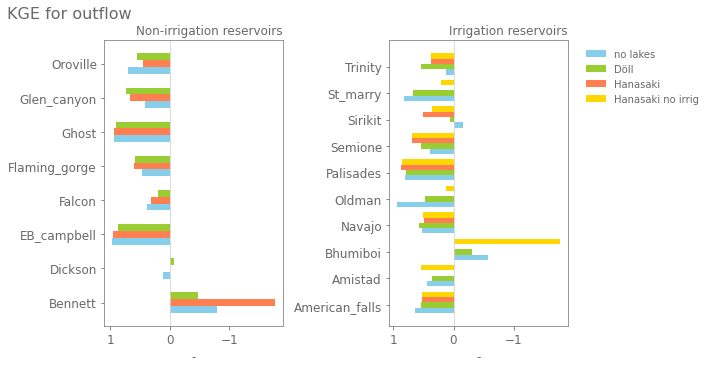

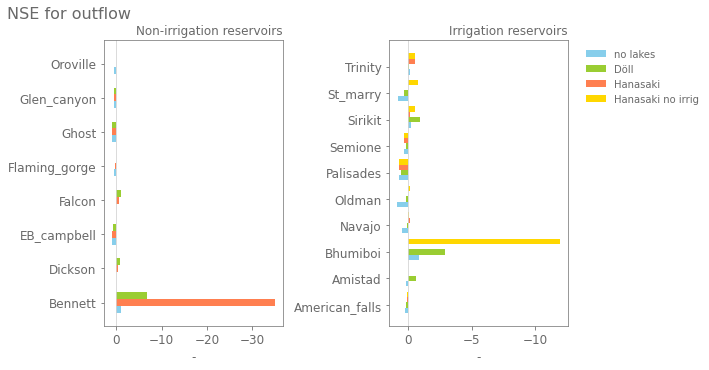

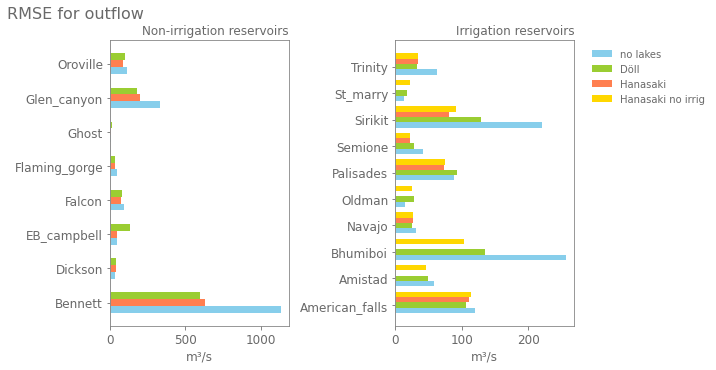

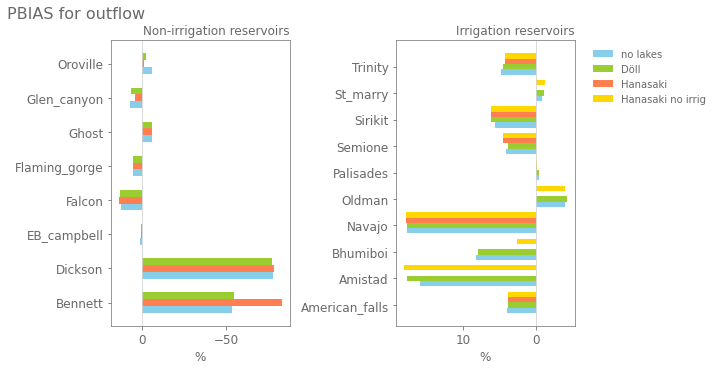

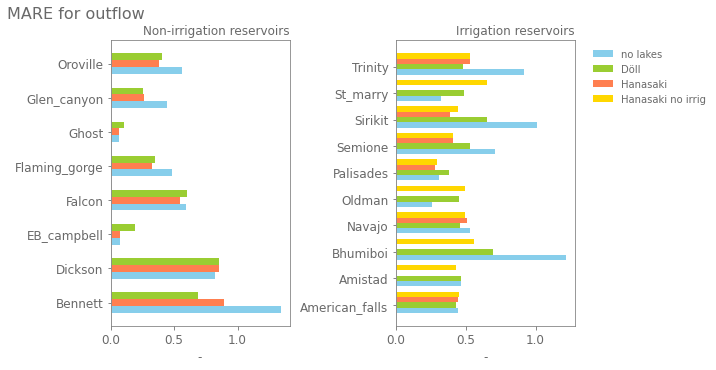

In [52]:
# plot metric per reservoir type: IRRIGATION
variable = 'outflow'
# combine metrics in dict
metrics_all_dict = {'KGE':kge_dict, 'NSE':nse_dict,'RMSE':rmse_dict, 'PBIAS': pbias_dict, 'MARE':mare_dict}

for metric in metrics_all_dict.keys(): 
    # initialise figure
    fig, axes = plt.subplots(1,2, figsize=(10,5))
    n=0
    # sort data

    metric_dict = metrics_all_dict[metric]


    # first plot: irrigation reservoirs 
    reservoir_subset_list = [ names_noirrig, names_irrig]
    title_subset_list = [ 'Non-irrigation reservoirs', 'Irrigation reservoirs']
    for reservoir_subset, title_subset in zip(reservoir_subset_list, title_subset_list): 

        # define which cases to plot for which category
        if title_subset == 'Non-irrigation reservoirs': 
            cases_toplot = ['nolake', 'H06_noirrig', 'natlake']
            cases_longname_toplot = ['no lakes',  'Döll', 'Hanasaki',]
            colors_toplot = [ 'skyblue', 'coral','yellowgreen' ]
        else: 
            cases_toplot = metric_dict[reservoir].keys()
            cases_longname_toplot = cases_longname
            colors_toplot = colors
            
        scores= np.empty((len(cases_toplot),len(reservoir_subset)))

        # get scores for irrigation reservoirs 
        for i,reservoir in enumerate(reservoir_subset):
            res_scores = []
            for case in cases_toplot: 
                res_scores.append(metric_dict[reservoir][case][variable].squeeze())
            scores[:,i] = np.array(res_scores)


        x_labels = reservoir_subset

        barWidth = 0.2  

        # Set position of bar on X axis
        barpositions = np.empty((len(cases),len(reservoir_subset)))
        barpositions[0,:] = np.arange(len(scores[0,:]))

        for i in range(1,barpositions.shape[0]):
            barpositions[i,:] =  [x + barWidth for x in barpositions[i-1,:] ]  

        ax = axes[n]
        for i,score in enumerate(scores):  
            ax.barh(barpositions[i,:], score,height = barWidth, label=cases_longname_toplot[i], color=colors_toplot[i])

        ax.set_yticks([r + barWidth for r in range(len(barpositions[0,:]))])
        ax.set_yticklabels(reservoir_subset)
        ax.set_title(title_subset,loc='right', fontsize=12)
        ax.axvline(0, linewidth=0.8, color='lightgray')
        if metric != 'RMSE' and metric !='MARE' : ax.invert_xaxis()
        if metric == 'RMSE': ax.set_xlabel('m³/s')
        elif metric == 'PBIAS': ax.set_xlabel('%')
        else: ax.set_xlabel('-')
        if n==1: ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
        n = n+1
    fig.tight_layout()
    fig.suptitle(metric+' for '+variable, fontsize=16,x=0.1, y= 1.02); 




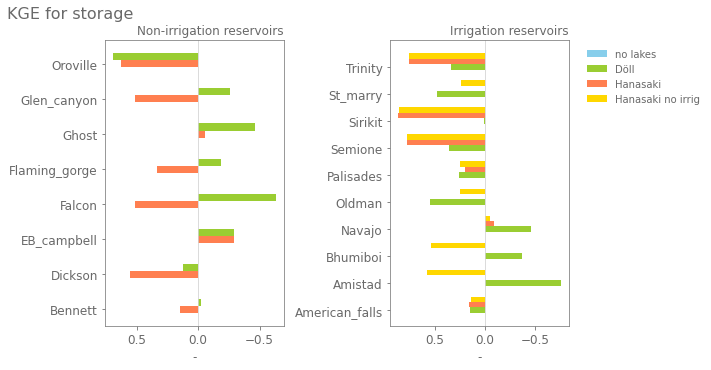

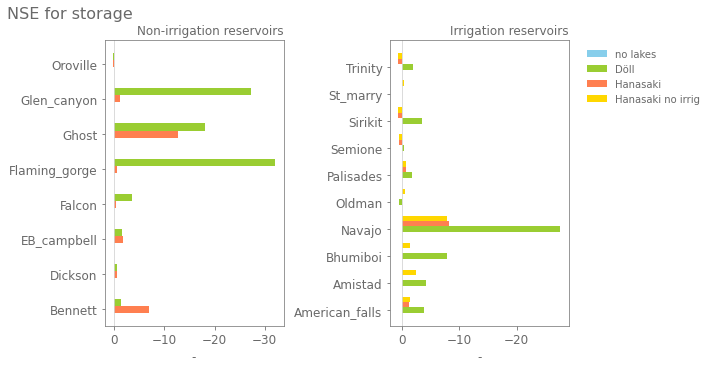

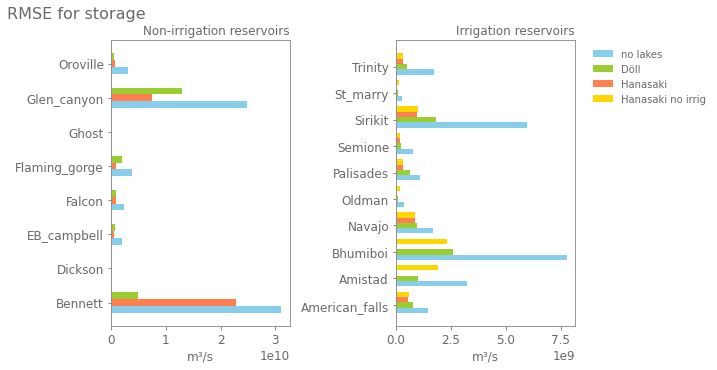

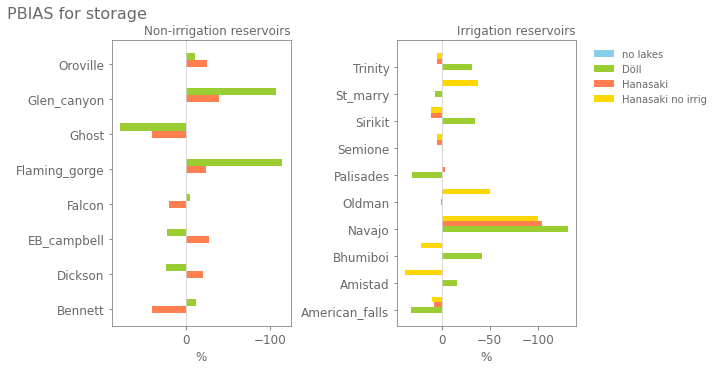

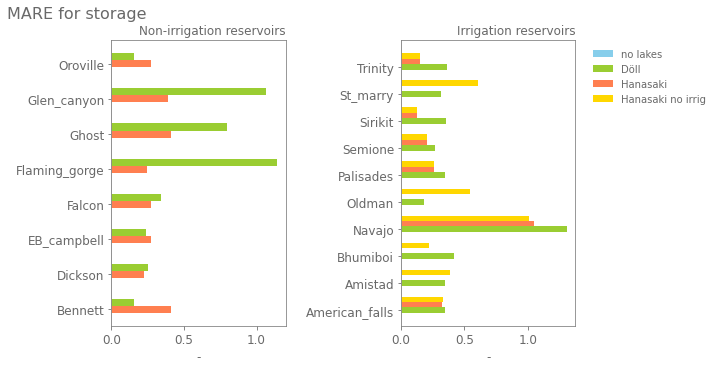

In [54]:
# plot metric per reservoir type: IRRIGATION
variable = 'storage'
# combine metrics in dict
metrics_all_dict = {'KGE':kge_dict, 'NSE':nse_dict,'RMSE':rmse_dict, 'PBIAS': pbias_dict, 'MARE':mare_dict}

for metric in metrics_all_dict.keys(): 
    # initialise figure
    fig, axes = plt.subplots(1,2, figsize=(10,5))
    n=0
    # sort data

    metric_dict = metrics_all_dict[metric]


    # first plot: irrigation reservoirs 
    reservoir_subset_list = [ names_noirrig, names_irrig]
    title_subset_list = [ 'Non-irrigation reservoirs', 'Irrigation reservoirs']
    for reservoir_subset, title_subset in zip(reservoir_subset_list, title_subset_list): 

        # define which cases to plot for which category
        if title_subset == 'Non-irrigation reservoirs': 
            cases_toplot = ['nolake', 'H06_noirrig', 'natlake']
            cases_longname_toplot = ['no lakes',  'Döll', 'Hanasaki',]
            colors_toplot = [ 'skyblue', 'coral','yellowgreen' ]
        else: 
            cases_toplot = metric_dict[reservoir].keys()
            cases_longname_toplot = cases_longname
            colors_toplot = colors
            
        scores= np.empty((len(cases_toplot),len(reservoir_subset)))

        # get scores for irrigation reservoirs 
        for i,reservoir in enumerate(reservoir_subset):
            res_scores = []
            for case in cases_toplot: 
                res_scores.append(metric_dict[reservoir][case][variable].squeeze())
            scores[:,i] = np.array(res_scores)


        x_labels = reservoir_subset

        barWidth = 0.2  

        # Set position of bar on X axis
        barpositions = np.empty((len(cases),len(reservoir_subset)))
        barpositions[0,:] = np.arange(len(scores[0,:]))

        for i in range(1,barpositions.shape[0]):
            barpositions[i,:] =  [x + barWidth for x in barpositions[i-1,:] ]  

        ax = axes[n]
        for i,score in enumerate(scores):  
            ax.barh(barpositions[i,:], score,height = barWidth, label=cases_longname_toplot[i], color=colors_toplot[i])

        ax.set_yticks([r + barWidth for r in range(len(barpositions[0,:]))])
        ax.set_yticklabels(reservoir_subset)
        ax.set_title(title_subset,loc='right', fontsize=12)
        ax.axvline(0, linewidth=0.8, color='lightgray')
        if metric != 'RMSE' and metric !='MARE' : ax.invert_xaxis()
        if metric == 'RMSE': ax.set_xlabel('m³/s')
        elif metric == 'PBIAS': ax.set_xlabel('%')
        else: ax.set_xlabel('-')
        if n==1: ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
        n = n+1
    fig.tight_layout()
    fig.suptitle(metric+' for '+variable, fontsize=16,x=0.1, y= 1.02); 




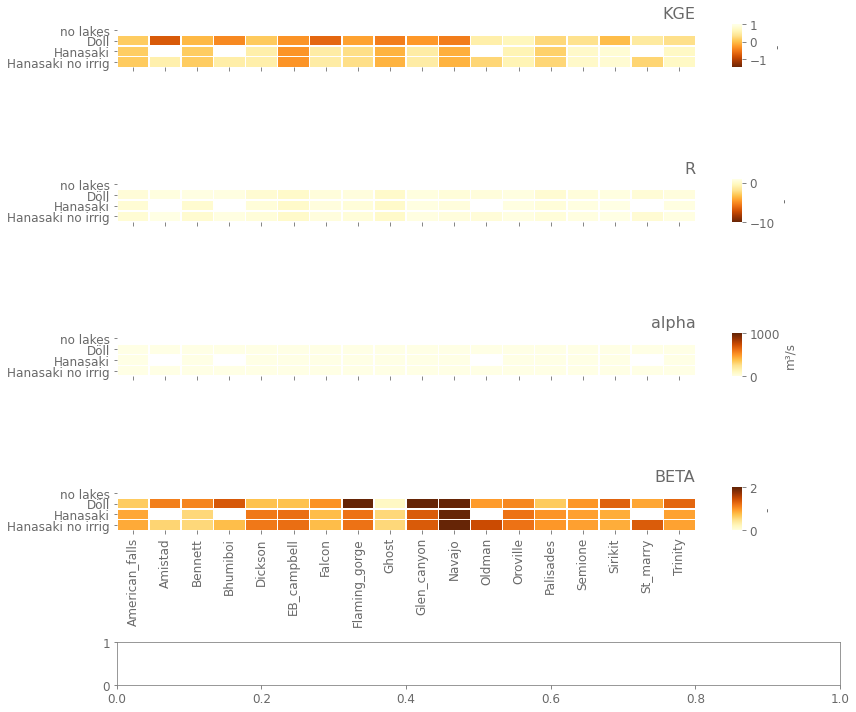

In [53]:
# HEAT PLOTS - all
variable = 'storage'
# combine metrics in dict
metrics_all_dict = {'KGE':kge_dict, 'R':r_dict,'alpha':alpha_dict, 'BETA': beta_dict}

# first plot: irrigation reservoirs 
reservoir_subset_list = [ names_big, names_small]
title_subset_list = ['multi-year', 'whithin-a-year']


reservoir_subset = metric_dict.keys()

fig, axes = plt.subplots(5,1, figsize=(12,10))


# properties per metric
cmaps = ['YlOrBr_r','YlOrBr_r', 'YlOrBr', 'YlOrBr','BrBG_r' ]
metric_units = ['-', '-', 'm³/s', '-', '%']
vmin = [-1.5, -10, 0, 0, -50]
vmax = [1, 1, 1000, 2, 50]
for n, metric in enumerate(metrics_all_dict.keys()): 
    # initialise figure
  
    # sort data
    
    metric_dict = metrics_all_dict[metric]

    
    scores= np.empty((len(cases),len(reservoir_subset)))

    # get scores for irrigation reservoirs 
    for i,reservoir in enumerate(reservoir_subset):
        for j, case in enumerate(metric_dict[reservoir].keys()):         
            scores[j,i] = metric_dict[reservoir][case][variable].squeeze()

    sns.heatmap(scores, ax=axes[n], linewidths=.5, cmap=cmaps[n], vmax=vmax[n], vmin=vmin[n], cbar_kws={"aspect": 4, "label": metric_units[n]}); 
    axes[n].set_yticklabels(cases_longname, rotation='horizontal'); 
    axes[n].set_title(metric, loc='right', fontsize=16); 
    if n < len(metrics_all_dict.keys())-1: 
        axes[n].set_xticklabels([]);
    else: 
        axes[n].set_xticklabels(reservoir_subset, rotation='vertical'); 


    fig.tight_layout()
     


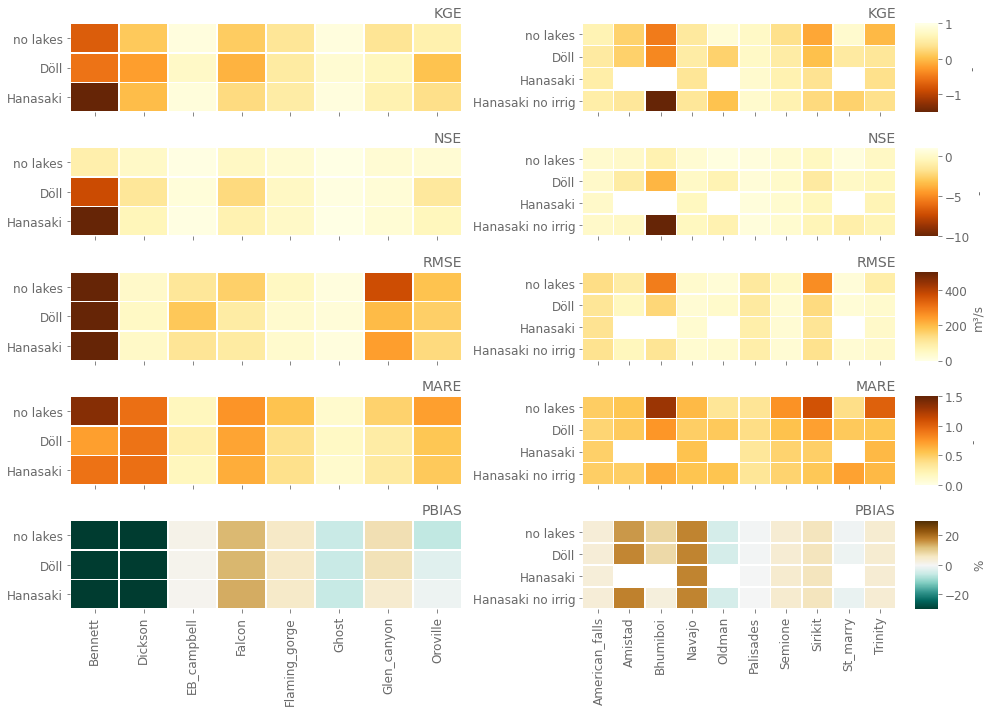

In [19]:
# HEAT PLOTS - per subset

# combine metrics in dict
metrics_all_dict = {'KGE':kge_dict, 'NSE':nse_dict,'RMSE':rmse_dict, 'MARE':mare_dict,'PBIAS': pbias_dict, }

# first plot: irrigation reservoirs 
reservoir_subset_list = [ names_noirrig, names_irrig]
title_subset_list = [ 'Non-irrigation reservoirs', 'Irrigation reservoirs']


fig, axes = plt.subplots(5,len(reservoir_subset_list), figsize=(14,10))

# counter
c = 0
for reservoir_subset, title_subset in zip(reservoir_subset_list, title_subset_list): 
    # define which cases to plot for which category
    if title_subset == 'Non-irrigation reservoirs': 
        cases_toplot = ['nolake', 'natlake', 'H06']
        cases_longname_toplot = cases_longname#['no lakes', 'Hanasaki non irrig', 'Döll' ]
    else: 
        cases_toplot = metric_dict[reservoir].keys()
        cases_longname_toplot = cases_longname
    
    
    # properties per metric
    cmaps = ['YlOrBr_r','YlOrBr_r', 'YlOrBr', 'YlOrBr','BrBG_r' ]
    metric_units = ['-', '-', 'm³/s', '-', '%']
    vmin = [-1.5, -10, 0, 0, -30]
    vmax = [1, 1, 500, 1.5,30]
    for n, metric in enumerate(metrics_all_dict.keys()): 
        # initialise figure

        # sort data

        metric_dict = metrics_all_dict[metric]


        scores= np.empty((len(cases_toplot),len(reservoir_subset)))

        # get scores for irrigation reservoirs 
        for i,reservoir in enumerate(reservoir_subset):
            for j, case in enumerate(cases_toplot):         
                scores[j,i] = metric_dict[reservoir][case][variable].squeeze()
        ax =  axes[n,c]
        # only colorbar in last column and ylabels in first column
        cbar_flag = False if c != len(reservoir_subset_list)-1 else True
        yticklabels = cases_longname #if c == 0 else []

        sns.heatmap(scores, ax=ax, linewidths=.5, cmap=cmaps[n], vmax=vmax[n], vmin=vmin[n], cbar = cbar_flag, cbar_kws={"aspect": 4, "label": metric_units[n]}); 
        ax.set_yticklabels(yticklabels, rotation='horizontal'); 
        ax.set_title(metric, loc='right', fontsize=14); 
        if n < len(metrics_all_dict.keys())-1: 
            ax.set_xticklabels([]);
        else: 
            ax.set_xticklabels(reservoir_subset, rotation='vertical'); 

    c= c+1

fig.tight_layout()



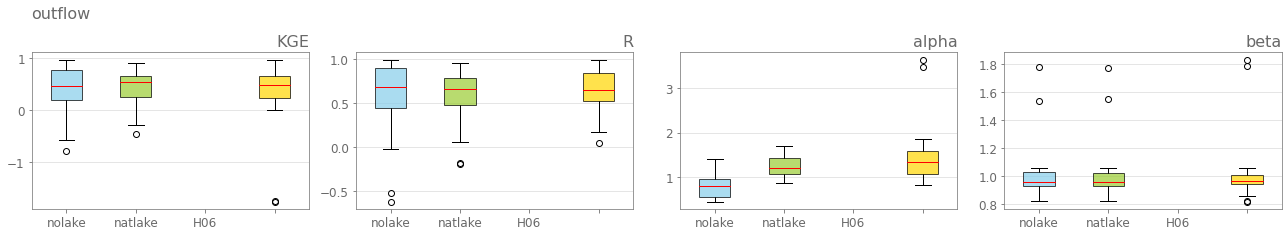

In [70]:
variable = 'outflow'
# sort data
metrics_all_dict = {'KGE':kge_dict, 'R':r_dict,'alpha':alpha_dict, 'beta': beta_dict}

dict_score_percase = {}
for n,metric in enumerate(metrics_all_dict.keys()): 
    metric_dict = metrics_all_dict[metric]
    
    
    metric_score_percase = np.empty((len(metric_dict.keys()), len(cases)))
    
    for i, case in enumerate(cases): 
        case_scores = []
        for reservoir in metric_dict.keys():
            case_scores.append(metric_dict[reservoir][case][variable].squeeze())
        metric_score_percase[:,i] = case_scores
    dict_score_percase[metric] = np.array(metric_score_percase)
    

#metrics = ['KGE', 'NSE','RMSE', 'MARE','PBIAS']
metrics = ['KGE', 'R','alpha', 'beta']

units = {'KGE': '-', 'NSE': '-', 'RMSE': 'm³/s', 'MARE': '-','PBIAS': '%'}
limits = {'KGE': (1,-1.5), 'NSE': (1,-4), 'RMSE':(-50,800), 'MARE': (0,1.5),'PBIAS': (-20,20)}

fig, axes = plt.subplots(1,len(metrics), figsize=(18,3))

for i, metric in enumerate(metrics):
    
    bplot = axes[i].boxplot(dict_score_percase[metric],patch_artist=True, medianprops=dict(color='r'));
    axes[i].yaxis.grid(True, linestyle='-', which='major', color='silver', alpha=0.5)
    axes[i].set_xticklabels(cases_simple)
    axes[i].set_title(metric, loc='right')
    #axes[i].set_ylabel(units[metric]);
    #axes[i].set_ylim(limits[metric])
    
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

fig.suptitle(variable, fontsize=16,x=0.05, y= 1.08); 
fig.tight_layout()

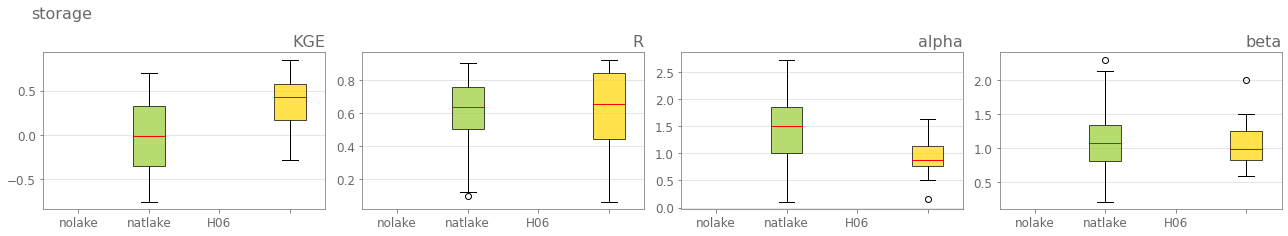

In [71]:
variable = 'storage'
# sort data
metrics_all_dict = {'KGE':kge_dict, 'R':r_dict,'alpha':alpha_dict, 'beta': beta_dict}

dict_score_percase = {}
for n,metric in enumerate(metrics_all_dict.keys()): 
    metric_dict = metrics_all_dict[metric]
    
    
    metric_score_percase = np.empty((len(metric_dict.keys()), len(cases)))
    
    for i, case in enumerate(cases): 
        case_scores = []
        for reservoir in metric_dict.keys():
            case_scores.append(metric_dict[reservoir][case][variable].squeeze())
        metric_score_percase[:,i] = case_scores
    dict_score_percase[metric] = np.array(metric_score_percase)
    

#metrics = ['KGE', 'NSE','RMSE', 'MARE','PBIAS']
metrics = ['KGE', 'R','alpha', 'beta']

units = {'KGE': '-', 'NSE': '-', 'RMSE': 'm³/s', 'MARE': '-','PBIAS': '%'}
limits = {'KGE': (1,-1.5), 'NSE': (1,-4), 'RMSE':(-50,800), 'MARE': (0,1.5),'PBIAS': (-20,20)}

fig, axes = plt.subplots(1,len(metrics), figsize=(18,3))

for i, metric in enumerate(metrics):
    
    bplot = axes[i].boxplot(dict_score_percase[metric],patch_artist=True, medianprops=dict(color='r'));
    axes[i].yaxis.grid(True, linestyle='-', which='major', color='silver', alpha=0.5)
    axes[i].set_xticklabels(cases_simple)
    axes[i].set_title(metric, loc='right')
    #axes[i].set_ylabel(units[metric]);
    #axes[i].set_ylim(limits[metric])
    
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

fig.suptitle(variable, fontsize=16,x=0.05, y= 1.08); 
fig.tight_layout()

## do now the same but for storage

In [ ]:
# plot metric per reservoir type: IRRIGATION
variable = 'storage'
# combine metrics in dict
metrics_all_dict = {'KGE':kge_dict, 'NSE':nse_dict,'RMSE':rmse_dict, 'PBIAS': pbias_dict, 'MARE':mare_dict}

for metric in metrics_all_dict.keys(): 
    # initialise figure
    fig, axes = plt.subplots(1,2, figsize=(10,5))
    n=0
    # sort data

    metric_dict = metrics_all_dict[metric]


    # first plot: irrigation reservoirs 
    reservoir_subset_list = [ names_noirrig, names_irrig]
    title_subset_list = [ 'Non-irrigation reservoirs', 'Irrigation reservoirs']
    for reservoir_subset, title_subset in zip(reservoir_subset_list, title_subset_list): 

        # define which cases to plot for which category
        if title_subset == 'Non-irrigation reservoirs': 
            cases_toplot = ['nolake', 'H06_noirrig', 'natlake']
            cases_longname_toplot = ['no lakes',  'Döll', 'Hanasaki',]
            colors_toplot = [ 'skyblue', 'coral','yellowgreen' ]
        else: 
            cases_toplot = metric_dict[reservoir].keys()
            cases_longname_toplot = cases_longname
            colors_toplot = colors
            
        scores= np.empty((len(cases_toplot),len(reservoir_subset)))

        # get scores for irrigation reservoirs 
        for i,reservoir in enumerate(reservoir_subset):
            res_scores = []
            for case in cases_toplot: 
                res_scores.append(metric_dict[reservoir][case][variable].squeeze())
            scores[:,i] = np.array(res_scores)


        x_labels = reservoir_subset

        barWidth = 0.2  

        # Set position of bar on X axis
        barpositions = np.empty((len(cases),len(reservoir_subset)))
        barpositions[0,:] = np.arange(len(scores[0,:]))

        for i in range(1,barpositions.shape[0]):
            barpositions[i,:] =  [x + barWidth for x in barpositions[i-1,:] ]  

        ax = axes[n]
        for i,score in enumerate(scores):  
            ax.barh(barpositions[i,:], score,height = barWidth, label=cases_longname_toplot[i], color=colors_toplot[i])

        ax.set_yticks([r + barWidth for r in range(len(barpositions[0,:]))])
        ax.set_yticklabels(reservoir_subset)
        ax.set_title(title_subset,loc='right', fontsize=12)
        ax.axvline(0, linewidth=0.8, color='lightgray')
        if metric != 'RMSE' and metric !='MARE' : ax.invert_xaxis()
        if metric == 'RMSE': ax.set_xlabel('m³')
        elif metric == 'PBIAS': ax.set_xlabel('%')
        else: ax.set_xlabel('-')
        if n==1: ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
        n = n+1
    fig.tight_layout()
    fig.suptitle(metric+' for '+variable, fontsize=16,x=0.1, y= 1.02); 




In [ ]:
variable  = 'storage'

# sort data
dict_score_percase = {}
for n,metric in enumerate(metrics_all_dict.keys()): 
    metric_dict = metrics_all_dict[metric]
    
    
    metric_score_percase = np.empty((len(metric_dict.keys()), len(cases_simple)))
    
    for i, case in enumerate(cases_simple): 
        case_scores = []
        for reservoir in metric_dict.keys():
            case_scores.append(metric_dict[reservoir][case][variable].squeeze())
        metric_score_percase[:,i] = case_scores
    dict_score_percase[metric] = np.array(metric_score_percase)
    

metrics = ['KGE', 'NSE','RMSE', 'MARE','PBIAS']

units = {'KGE': '-', 'NSE': '-', 'RMSE': 'm³', 'MARE': '-','PBIAS': '%'}
limits = {'KGE': (1,-1), 'NSE': (1,-9), 'RMSE':(-1e9,9e9), 'MARE': (0,1),'PBIAS': (-120,120)}

fig, axes = plt.subplots(1,len(metrics), figsize=(18,3))

for i, metric in enumerate(metrics):
    
    bplot = axes[i].boxplot(dict_score_percase[metric],patch_artist=True, medianprops=dict(color='r'));
    axes[i].yaxis.grid(True, linestyle='-', which='major', color='silver', alpha=0.5)
    axes[i].set_xticklabels(cases_simple)
    axes[i].set_title(metric, loc='right')
    axes[i].set_ylabel(units[metric]);
    axes[i].set_ylim(limits[metric])
    
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

fig.tight_layout()
fig.suptitle(variable, fontsize=16,x=0.05, y= 1.08); 
